In [1]:
import numpy as np

import scipy.io
import scipy.stats

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import seaborn as sns 

import ordpy
import tqdm
import igraph
import string

from numpy import linalg as LA
from scipy.signal import find_peaks

import warnings
import colorednoise

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))

In [2]:
#Statistical Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#evaluation
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

In [3]:
# # Results for randomized series.

def baseline_random(shape='Circle', camera=1, n_shuffling=100):
    """
    Calculates the average clustering accuracy for chaotic and tumbling 
    falling papers for shuffled time series of observable area.
    
    Parameters
    ----------
    shape      : 'Circle', 'Hexagon', 'Square' or 'Cross'.
    camera     : 1 or 2.
    n_shuffling: number of times the time series are shuffled
                 before calculating their mean (clustering)
                 accuracy.
    ----------
    
    Returns the average (clustering) accuracy for embedding dimensions
    dx=3, 4, 5 and 6.
    """
    if shape=='Hexagon':
        shape_trajectories, shape_cam1, shape_cam2, shape_radii, shape_conditions, _ = trajectory_cleaning(shape)
        shape_trajectories = np.delete(shape_trajectories, [38, 143, 144])
        shape_cam1         = np.delete(shape_cam1, [38, 143, 144])
        shape_cam2         = np.delete(shape_cam2, [38, 143, 144])
        shape_radii        = np.delete(shape_radii, [38, 143, 144])
        shape_conditions   = np.delete(shape_conditions, [38, 143, 144])
        
        shape_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape))['behaviourHuman'][0]
        shape_human_class = np.delete(shape_human_class, [142])

        shape_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape))['behaviourAuto'].flatten()
        shape_feat_class  = np.delete(shape_feat_class, [142])
        
    elif shape=='Cross':
        shape_trajectories, shape_cam1, shape_cam2, shape_radii, shape_width, shape_conditions, _  = trajectory_cleaning(shape)
        shape_dx, shape_dy, shape_dz, shape_pathlen, shape_time, shape_w, shape_vz                 = original_features(shape_trajectories, shape_cam1, shape_cam2)

        shape_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape))['behaviourHuman'][0]
        shape_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape))['behaviourAuto'].flatten()
    else:    
        #loading cleaned trajectories and some features.
        shape_trajectories, shape_cam1, shape_cam2, shape_radii, shape_conditions, _  = trajectory_cleaning(shape)
        shape_dx, shape_dy, shape_dz, shape_pathlen, shape_time, shape_w, shape_vz    = original_features(shape_trajectories, shape_cam1, shape_cam2)

        #Classifications
        shape_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape))['behaviourHuman'][0]
        shape_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape))['behaviourAuto'].flatten()

    
    traj_randomized                 = []

    for dx_ in range(3,7):
        temp = []
        for i in tqdm.tqdm(range(n_shuffling)):
            shape_ce               = []
            shape_cluster          = []
            shape_size             = []
            shape_human_chaos_tumb = []
            
            for i, st, ts1, ts2, class_, size_ in zip(range(len(shape_trajectories)), shape_trajectories, shape_cam1, shape_cam2, shape_human_class, shape_radii):
            #Complexity-Entropy plane
                if class_==3:
                    pass
                else:
                    if camera==1:
                        ts = ts1
                    else:
                        ts = ts2
                    np.random.shuffle(ts)
                    h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
                    shape_ce.append((h_, c_))
                    shape_cluster.append((h_, c_))
                    shape_size.append(size_)
                    shape_human_chaos_tumb.append(class_)

            #clustering to generate the second panel data
            shape_cluster          = np.asarray(shape_cluster).reshape(-1,2) #standardizing permutation features
            scaler                 = StandardScaler()
            shape_cluster_features = scaler.fit_transform(shape_cluster)
            shape_pred             = KMeans(n_clusters=2, random_state=42).fit(shape_cluster_features).labels_ 

            _, b = np.unique(shape_human_class[shape_human_class!=3], return_counts=True)
            b    = b/b.sum()

            shape_pred_copy_1 = np.where(shape_pred==0, 2, shape_pred)

            shape_pred_copy_2 = np.where(shape_pred==1, 2, shape_pred)
            shape_pred_copy_2 = np.where(shape_pred==0, 1, shape_pred_copy_2)

            shape_pred_copy_2 = sum(shape_human_chaos_tumb==shape_pred_copy_2)/len(shape_pred_copy_2)
            shape_pred_copy_1 = sum(shape_human_chaos_tumb==shape_pred_copy_1)/len(shape_pred_copy_1)

            if shape_pred_copy_2>shape_pred_copy_1:
                shape_pred_copy=shape_pred_copy_2
            else:
                shape_pred_copy=shape_pred_copy_1

            temp.append(shape_pred_copy)
        traj_randomized.append(temp)

    print('Shape: {}'.format(shape).upper(), '\n')
    _, b = np.unique(shape_human_class, return_counts=True)
    b    = 100*b/b.sum()
    print('Relative abundance of tumbling, chaotic and steady (periodic) trajectories (as categorized by experts):')

    print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
    print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
    print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

    _, b = np.unique(shape_human_class[shape_human_class!=3], return_counts=True)
    b    = 100*b/b.sum()
    print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
    print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
    print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')

    print('Average clustering accuracy for embedding dimensions dx=3, 4, 5 and 6.')
    return np.mean(traj_randomized, axis=1)

# Functions' definitions

In [4]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [5]:
%matplotlib inline

#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [6]:
def normalize(array):
    """
    Normalizes an array between 0 and 1.
    """
    return (array-array.min())/(array.max()-array.min())

In [7]:
def trajectory_cleaning(shape):
    """
    Cleans and segments the original trajectories of falling papers
    using the data and parameters established by Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    shape (str): shape of falling paper. Either "Circle", 
                 "Square" or "Cross".
    ----------
    Returns several arrays or floats containing time series
    or characteristics of the falling papers:
    
    - series of tridimensional trajectories; 
    - series of observable area (camera 1); 
    - series of observable area (camera 2);
    - radii of falling paper shape;
    - width of falling paper shape (in case shape=="Cross");
    - initial condition (0 for robotic arm in horizontal position,
      1 for vertical position);
    - preclassification of cleaned trajectories (3 for periodic falling and nan 
    for possibly chaotic or tumbling time series).
                         
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    ##########################################################################################
    #Data processing

    #Improving data structure. Extracting data from data{shape}.mat and loading it into data arrays
    disk_data = scipy.io.loadmat('classification/data{}.mat'.format(shape))

    #initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
    disk_initcons = []
    for i in range(len(disk_data['data'][0])):
        disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
    disk_initcons = np.asarray(disk_initcons)

    # radii of the disks dropped
    disk_radii = []
    for i in range(len(disk_data['data'][0])):
        disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
    disk_radii = np.asarray(disk_radii)

    # width of the crosses dropped
    if shape=='Cross':
        disk_width = []
        for i in range(len(disk_data['data'][0])):
            disk_width.append(disk_data['data'][0][i]['width'][0][0][0][0])
        disk_width = np.asarray(disk_width)

    # camera 1 observable area?
    disk_cam1 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0].flatten())
    disk_cam1 = np.asarray(disk_cam1)

    # camera 2 observable area?
    disk_cam2 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0].flatten())
    disk_cam2 = np.asarray(disk_cam2)

    # coordinates (x, y, z) along trajectory from 1m high to the floor.
    disk_trajectories = []
    for i in range(len(disk_data['data'][0])):
        disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
    disk_trajectories = np.asarray(disk_trajectories)
    ##########################################################################################

    
    #Cleaning trajectories
    clean_disk_trajectories = []
    clean_disk_cam2         = []
    clean_disk_cam1         = []
    
    clean_disk_initcons     = []
    clean_disk_class        = []
    clean_disk_radii        = []
    clean_disk_width        = []

    for i in range(len(disk_trajectories)):
        #vertical trajectory
        z         = disk_trajectories[i][::,2][::-1]

        #finding the index to remove the last 5cm of fall
        cut_index = 0
        for z_ in z:
            if z_<0.05:
                cut_index -= 1
            else: break

        if not cut_index==0:
            # removing the last 5 centimeters of the fall.
            trajectory = disk_trajectories[i][:cut_index].copy() 

            #removing  the last 5cm of fall from observable area series
            area_cam2 = disk_cam2[i][:cut_index].copy()
            area_cam1 = disk_cam1[i][:cut_index].copy()
        else:
            trajectory = disk_trajectories[i].copy() 
            area_cam2  = disk_cam2[i].copy()
            area_cam1  = disk_cam1[i].copy()


    #(original comment) Segment steady and periodic behaviours from trajectories. 
        if disk_initcons[i]==0: #(original comment) We only see steady and periodic from horizontal initial condition.
            tc=0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<(0.2*disk_radii[i]) and tc<len(trajectory[::,1]):
                tc=tc+1

            if tc>1: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
    #             pass
    #             print(steady_index)
                clean_disk_trajectories.append(trajectory[:tc+1])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(3)
                clean_disk_cam1.append(area_cam1[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                clean_disk_cam2.append(area_cam2[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass
    #             print('dividiu: ', i)
    #             print('counter steady:', counter)

                if len(trajectory)-tc>10: #second part of the sliced original trajectory.
                    clean_disk_trajectories.append(trajectory[tc:])
                    clean_disk_initcons.append(0)
                    clean_disk_radii.append(disk_radii[i])
                    clean_disk_class.append(np.nan)
                    clean_disk_cam1.append(area_cam1[tc:])
                    clean_disk_cam2.append(area_cam2[tc:])
                    # width of the crosses dropped
                    if shape=='Cross':
                        clean_disk_width.append(disk_width[i])
                    else: pass

            else: #no segmentation; only one behavior throughout the whole fall
                clean_disk_trajectories.append(trajectory)
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1)
                clean_disk_cam2.append(area_cam2)
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass


        else: #(original comment) Vertical initial condition, no steady and peridoic behaviour
            tc = 0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<0.01 and tc<len(trajectory[::,1]):
                tc = tc+1

            if len(trajectory[::,1])-tc>10:
                clean_disk_trajectories.append(trajectory[tc:])
                clean_disk_initcons.append(1)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1[tc:])
                clean_disk_cam2.append(area_cam2[tc:])
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass

    if shape=='Cross':
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_width, clean_disk_initcons, clean_disk_class
    else:
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_initcons, clean_disk_class

def original_features(trajectories, area_cam1, area_cam2):
    """
    Extracts physical measures from time series of 
    falling paper. For more information, see Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    trajectories (array): set of time series of  trajectories of 
                          falling papers.
    ----------
    Returns several arrays containing 
    characteristics of falling papers:
    
    - displacement in the x axis; 
    - displacement in the y axis; 
    - displacement in the z axis; 
    - length of the trajectory;
    - duration of the fall;
    - angular velocity;
    - standard deviation of the velocity of fall
    in the z axis;
        
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    clean_disk_trajectories = trajectories
    clean_disk_cam1         = area_cam1
    clean_disk_cam2         = area_cam2
    
    dx         = []
    dy         = []
    dz         = []
    pathlength = []
    time       = []
#     X          = []
    Osc        = []
    SpeedZ     = []
    
    for i in range(len(clean_disk_trajectories)):
        stop = 0
        d    = 0 

        for j in range(1, len(clean_disk_trajectories[i])):
            if LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])>0.1:
                stop==1
                break
            d = d + LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])

        if stop==0:
            pathlength.append(d)
            z = clean_disk_trajectories[i][::,2]
            dz.append(np.absolute(clean_disk_trajectories[i][::,2][-1]-clean_disk_trajectories[i][::,2][0]))
            dy.append(clean_disk_trajectories[i][::,1][-1]-clean_disk_trajectories[i][::,1][0])
            dx.append(clean_disk_trajectories[i][::,0][-1]-clean_disk_trajectories[i][::,0][0])
            time.append(len(clean_disk_trajectories[i])*1/98)

            locs1 = find_peaks(clean_disk_cam1[i])[0]
            locs2 = find_peaks(clean_disk_cam2[i])[0]

            Osc.append((len(locs1)+len(locs2))/(2*time[-1]))
            SpeedZ.append(np.std(np.diff(z)))
#             X.append([Osc, SpeedZ])

    return dx, dy, dz, pathlength, time, Osc, SpeedZ

In [8]:
#Skew tent map
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    """
    Iterates the Skew tent map.
    
    Parameters
    ----------
    n     : time series length.
    omega : map parameter.
    x0    : initial condition.
    ----------
    Returns an array corresponding to a 
    time series.
    """
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    
    return x

#Logistic map
def logistic_map(n=2**15, r=4, x0=0.4):
    """
    Iterates the logistic map.
    
    Parameters
    ----------
    n  : number of map iterations (length of the series).
    x0 : initial population ([0,1] interval)
    r  : intrinsic growth rate (r >= 0; interesting in [0,4] because then, it 
         maps the orbit to the [0,1] interval to itself.)
    ----------
    Returns a logistic map orbit.
    """
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
        
    return x

#Henon's map
def henon_map(n=2**15, a=1.4, b=0.3, x0=.5, y0=.5):
    """
    Paramenters
    -----------
    n  : time series length.
    a  : map parameter.
    b  : map parameter.
    x0 : initial condition.
    y0 : initial condition.
    -----------
    
    Returns the x and y variables of Henón's map.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("error")
            
        bool_ = False
        while bool_==False:        
            try:
                x    = np.zeros(n)
                y    = np.zeros(n)

                x[0] = x0
                y[0] = y0

                for i in range(1, n):
                    x[i] = 1 - a*x[i-1]**2 + y[i-1]
                    y[i] = b*x[i-1]

                bool_ = True

            except RuntimeWarning: #changes the random inital condition
                x0 = np.random.uniform()
                y0 = np.random.uniform()

    return x, y

#Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):
    """
    
    Parameters
    ----------
    n : time series length
    z :  map parameter
    ----------
    Returns an orbit of an iterated Schuster map.
    """
    z    = float(z)
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    
    return x

# Disk Analysis

In [9]:
shape_ = 'Circle'

#loading cleaned trajectories and some features.
circle_trajectories, circle_cam1, circle_cam2, circle_radii, circle_conditions, _  = trajectory_cleaning(shape_)
circle_dx, circle_dy, circle_dz, circle_pathlen, circle_time, circle_w, circle_vz  = original_features(circle_trajectories, circle_cam1, circle_cam2)

#Classifications
circle_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Circle'))['behaviourHuman'][0]
circle_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Circle'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Disk - Original features plane (angular velocity vs linear velocity)

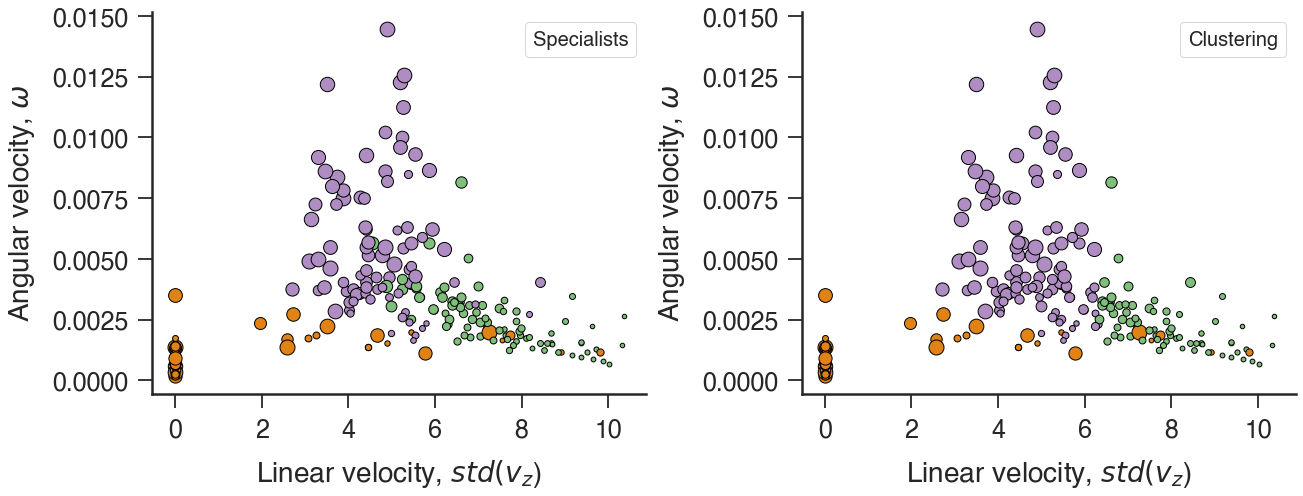

In [10]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214" #periodic
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling

orange_ = "#e08214" #periodic
purple_ = "#af8dc3" #chaotic
green_  = "#7fbf7b" #tumbling

grey_   = "#bababa"

#first panel
for osc, vz, class_, size_ in zip(circle_w, circle_vz, circle_human_class, circle_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(circle_w, circle_vz, circle_feat_class, circle_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Specialists'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Clustering'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Disk - Complexity-entropy - 2D Observable area time series

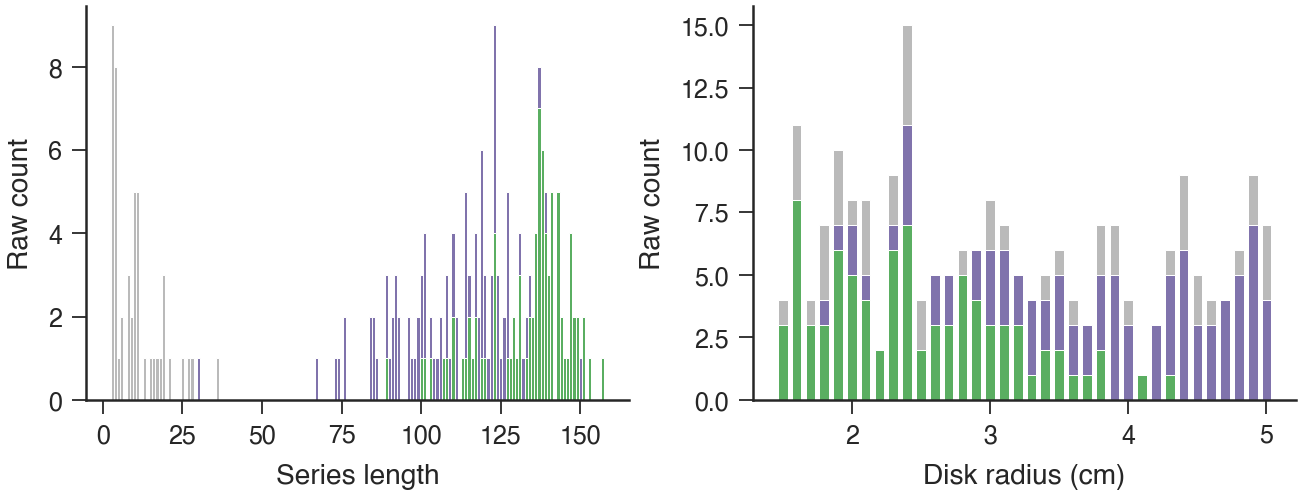

In [15]:
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in circle_trajectories])
x, y    = np.unique([len(i) for i in circle_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(circle_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in circle_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(circle_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Disk radius (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

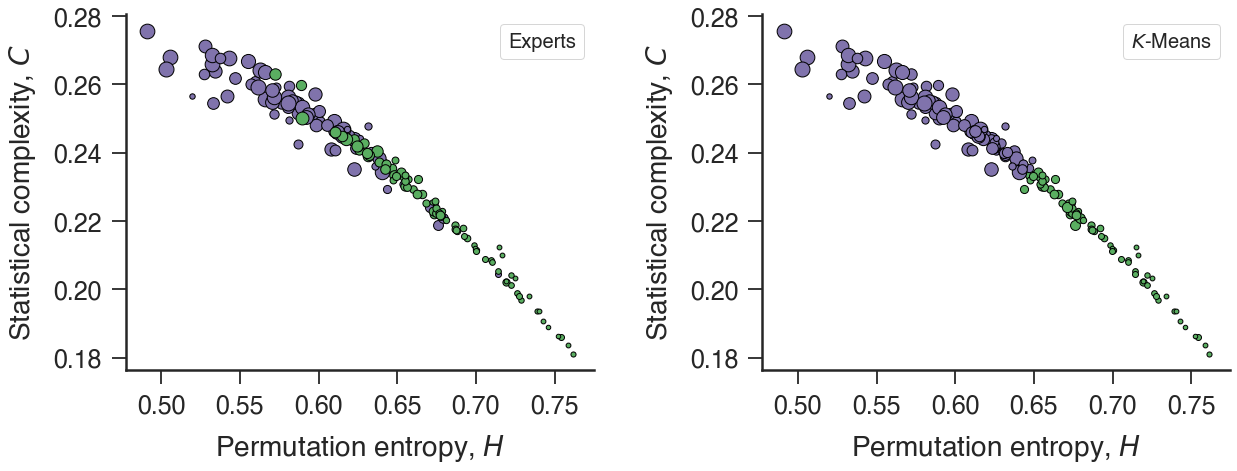

In [136]:
#Generating data to plot
dx_                     = 3
circle_ce_final         = []
circle_cluster_final    = []
circle_size             = []
circle_human_chaos_tumb = []
circle_lengths          = []


for i, st, ts1, ts2, class_, size_ in zip(range(len(circle_trajectories)), circle_trajectories, circle_cam1, circle_cam2, circle_human_class, circle_radii):

    if class_==3: #steady or periodic time series
        try:
            ts = ts1
            h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
            circle_ce_final.append((h_, c_))
            circle_lengths.append(len(ts))
        except:
            print("Found a series shorter than {}.".format(dx_))
            circle_ce_final.append((0,0))
            circle_lengths.append(len(ts))
            
    else: #tumbling or chaotic time series
        ts = ts1
        h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
        circle_ce_final.append((h_, c_))
        circle_lengths.append(len(ts))
        circle_cluster_final.append((h_, c_))
        circle_size.append(size_)
        circle_human_chaos_tumb.append(class_)
################################################
        
#Figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(circle_ce_final, circle_human_class, circle_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
    if class_ == 3:
        pass
    
#clustering to generate the second panel data
circle_cluster_final          = np.asarray(circle_cluster_final).reshape(-1,2) #standardizing permutation features
scaler                        = StandardScaler()
circle_cluster_final_features = scaler.fit_transform(circle_cluster_final)
circle_pred                   = KMeans(n_clusters=2, random_state=42).fit(circle_cluster_final_features).labels_

for (h_, c_), class_, size_ in zip(circle_cluster_final, circle_pred, circle_size): 
    if class_==1:
        ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_, zorder=0)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/circle-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

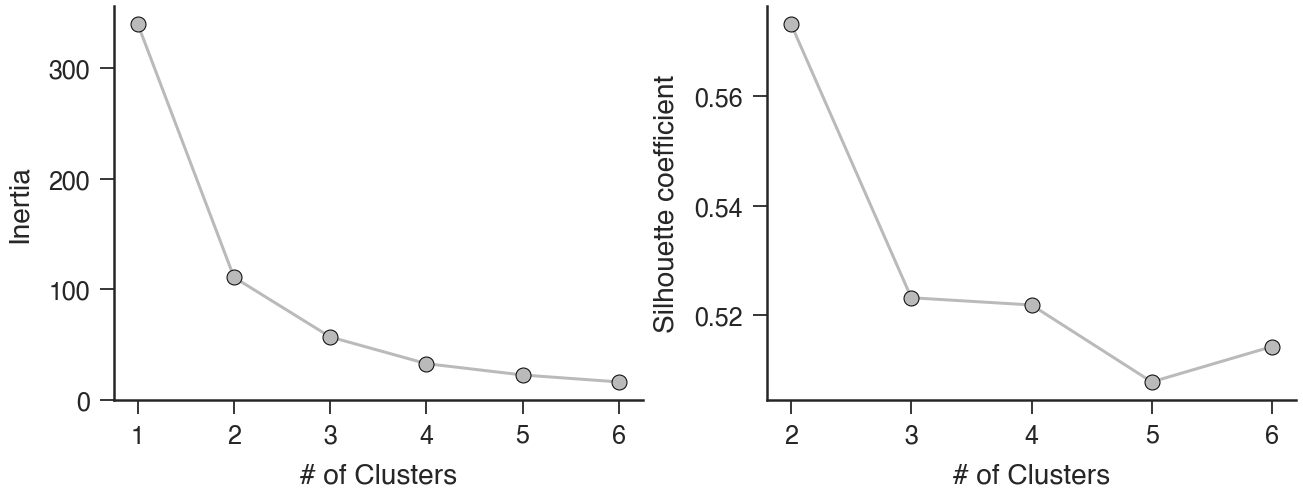

In [12]:
inertia                       = []
KMEANS                        = []
circle_cluster_final          = np.asarray(circle_cluster_final).reshape(-1,2) #standardizing permutation features
scaler                        = StandardScaler()
circle_cluster_final_features = scaler.fit_transform(circle_cluster_final)

for k in range(1,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(circle_cluster_final_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(circle_cluster_final_features))
    # circle_pred             = KMeans(n_clusters=2, random_state=42).fit(circle_cluster_final_features).labels_ 
    

silhouette_kmeans = [silhouette_score(circle_cluster_final_features, kmean_.labels_) for kmean_ in KMEANS[1:]]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([1,2,3,4,5,6], inertia, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [40]:
# _, b = np.unique(circle_human_class, return_counts=True)
# b    = 100*b/b.sum()

# print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
# print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
# print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
# print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

# _, b = np.unique(circle_human_class[circle_human_class!=3], return_counts=True)
# b    = 100*b/b.sum()
# print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
# print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
# print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')

print('Comparison between our "permutation clustering" and the original clustering based on time series statistics:', '\n')
# circle_pred_copy = np.where(circle_pred==0, 2, circle_pred)

circle_pred_copy = np.where(circle_pred==1, 2, circle_pred)
circle_pred_copy = np.where(circle_pred==0, 1, circle_pred_copy)
print('Accuracy using permutation entropy (statistics) strategy: ', sum(circle_human_chaos_tumb==circle_pred_copy)/len(circle_pred_copy))
print('Accuracy of the original paper                          : ', sum(circle_feat_class[circle_feat_class!=3]==circle_human_class[circle_human_class!=3])/len(circle_feat_class[circle_feat_class!=3]))

Comparison between our "permutation clustering" and the original clustering based on time series statistics: 

Accuracy using permutation entropy (statistics) strategy:  0.8647058823529412
Accuracy of the original paper                          :  0.8529411764705882


In [14]:
baseline_random(shape='Circle', camera=1)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]

SHAPE: CIRCLE 

Relative abundance of tumbling, chaotic and steady (periodic) trajectories (as categorized by experts):
Tumbling         = 39.0%
Chaotic          = 39.0%
Steady/periodic  = 22.0% 

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 49.0%
Chaotic  = 51.0% 

Average clustering accuracy for embedding dimensions dx=3, 4, 5 and 6.


array([0.53464706, 0.57976471, 0.69058824, 0.74388235])

In [14]:
hc_fbm_dx3 = np.load('figures/series-data/hc_fbm_dx3.npy')
hc_fbm_dx4 = np.load('figures/series-data/hc_fbm_dx4.npy')
hc_fbm_dx5 = np.load('figures/series-data/hc_fbm_dx5.npy')
hc_fbm_dx6 = np.load('figures/series-data/hc_fbm_dx6.npy')

hc_fgn_dx3 = np.load('figures/series-data/hc_fgn_dx3.npy')
hc_fgn_dx4 = np.load('figures/series-data/hc_fgn_dx4.npy')
hc_fgn_dx5 = np.load('figures/series-data/hc_fgn_dx5.npy')
hc_fgn_dx6 = np.load('figures/series-data/hc_fgn_dx6.npy')

hc_schuster = np.load('figures/series-data/hc_schuster.npy')
hc_stentmap = np.load('figures/series-data/hc_stentmap.npy')
hc_henon_x  = np.load('figures/series-data/hc_henon_x.npy')
hc_logistic = np.load('figures/series-data/hc_logistic.npy')
hc_knoise   = np.load('figures/series-data/hc_knoise.npy')

4it [00:01,  2.25it/s]


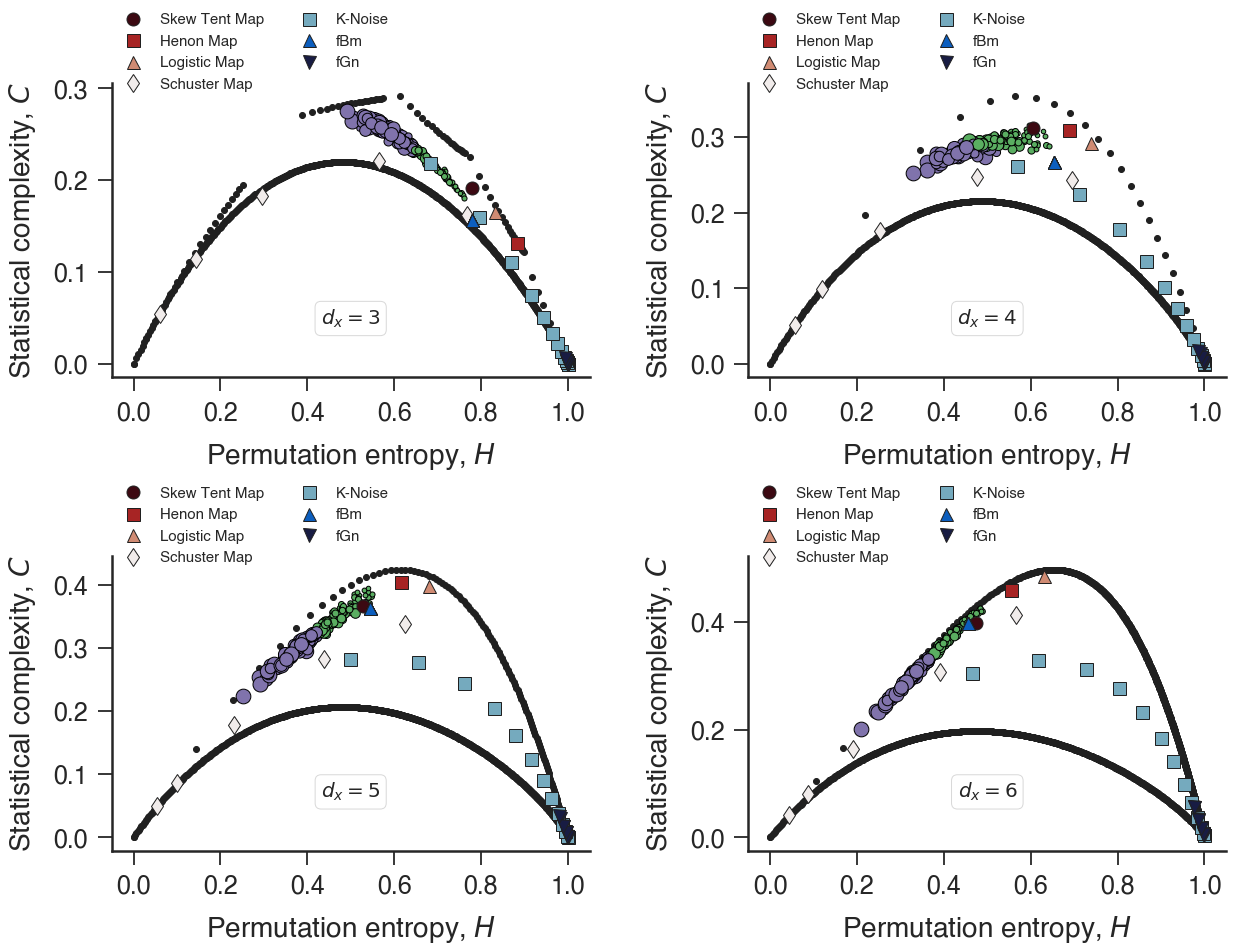

In [15]:
#figure creation
f, ax = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(scale=.95, nrows=2, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"
##################################################################

for dx_, hc_fgn, hc_fbm, hc_schuster_, hc_stentmap_, hc_henon_x_, hc_logistic_, hc_knoise_ in tqdm.tqdm(zip(range(3,7), np.asarray([hc_fgn_dx3, hc_fgn_dx4, hc_fgn_dx5, hc_fgn_dx6]), 
                                                                                                        np.asarray([hc_fbm_dx3, hc_fbm_dx4, hc_fbm_dx5, hc_fbm_dx6]), 
                                                                                                        hc_schuster, hc_stentmap, hc_henon_x, hc_logistic, hc_knoise)):
    k       = int(dx_)
    hc_data = [hc_stentmap_, hc_henon_x_, hc_logistic_, hc_schuster_, hc_knoise_, hc_fbm, hc_fgn]
    labels  = ['Skew Tent Map', 'Henon Map', 'Logistic Map', 'Schuster Map', 'K-Noise','fBm', 'fGn']
    markers = ['o', 's', '^', 'd', 's', '^', 'v']
    colors  = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 


    #palettable.cmocean.diverging.Balance_7_r.hex_colors
    colors = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 

    for data_, marker_, color_, label_, cnt in zip(hc_data, markers, colors, labels, range(len(hc_data))):
        #point plotting
        h_, c_ = data_.T
        ax[k-3].plot(h_, c_, marker_, markersize=13, markeredgecolor='#202020', color=color_, label=label_)
        
    if dx_==3:
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_, m =20).T  #(this variable is defined in the cell above)
    else:    
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_).T  #(this variable is defined in the cell above)

    ax[k-3].plot(hmin, cmin, '.', marker='o', color='#202020', zorder=0)
    ax[k-3].plot(hmax, cmax, '.', marker='o', color='#202020', zorder=0)

    ax[k-3].set_ylabel('Statistical complexity, $C$')
    ax[k-3].set_xlabel('Permutation entropy, $H$')
    ax[k-3].annotate('$d_x = {}$'.format(dx_), (.5, .2),
                   va='center',
                   ha='center',
                   xycoords='axes fraction',
                   fontsize=20,
                   bbox={
                       'boxstyle': 'round',
                       'fc': 'white',
                       'alpha': 1,
                       'ec': '#d9d9d9'
                   })
    ax[k-3].legend(frameon=False, loc=(0, .95), ncol=2, fontsize=15)

    #################################################################
    circle_ce               = []
    circle_lengths          = []
    circle_cluster          = []
    circle_size             = []
    circle_human_chaos_tumb = []

    for i, st, ts1, ts2, class_, size_ in zip(range(len(circle_trajectories)),circle_trajectories,circle_cam1,circle_cam2,circle_human_class,circle_radii):
        if class_==3: #steady or periodic time series
            try:
                ts = ts1
                h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
                circle_ce.append((h_, c_))
            except:
                circle_ce.append((0,0))

        else: #tumbling or chaotic time series
            ts = ts1 
            h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
            
            circle_ce.append((h_, c_))
            circle_lengths.append(len(ts1))
            circle_cluster.append((h_, c_))
            circle_size.append(size_)
            circle_human_chaos_tumb.append(class_)

    #clustering to generate the second panel data
    circle_cluster          = np.asarray(circle_cluster).reshape(-1,2) #standardizing permutation features
    scaler                  = StandardScaler()
    circle_cluster_features = scaler.fit_transform(circle_cluster)
    circle_pred             = KMeans(n_clusters=2, random_state=42).fit(circle_cluster_features).labels_ 

    for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_size): #marker size proportional to series length
    # for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_lengths): #marker size proportional to series length
        if class_==0:
            ax[k-3].plot(h_, c_, marker='o', markersize=300*size_, markeredgecolor='black', color=green_, zorder=0)
        else:
            ax[k-3].plot(h_,c_,  marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    

for i in range(4):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
f.savefig('figures/final_figures/observable-area-circle-maps-noises-dx3to6.svg', bbox_inches='tight')
# f.savefig('figures/trajectory-circle-schuster.svg'.format(dx_, 2), bbox_inches='tight')

# Hexagon

In [16]:
shape_ = "Hexagon"

hex_trajectories, hex_cam1, hex_cam2, hex_radii, hex_conditions, _ = trajectory_cleaning(shape_)
hex_trajectories = np.delete(hex_trajectories, [38, 143, 144])
hex_cam1         = np.delete(hex_cam1, [38, 143, 144])
hex_cam2         = np.delete(hex_cam2, [38, 143, 144])
hex_radii        = np.delete(hex_radii, [38, 143, 144])
hex_conditions   = np.delete(hex_conditions, [38, 143, 144])

hex_dx, hex_dy, hex_dz, hex_pathlen, hex_time, hex_w, hex_vz       = original_features(hex_trajectories, hex_cam1, hex_cam2)

hex_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape_))['behaviourHuman'][0]
hex_human_class = np.delete(hex_human_class, [142])

hex_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['behaviourAuto'].flatten()
hex_feat_class  = np.delete(hex_feat_class, [142])

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Hexagon - Original features plane (angular velocity vs linear velocity)

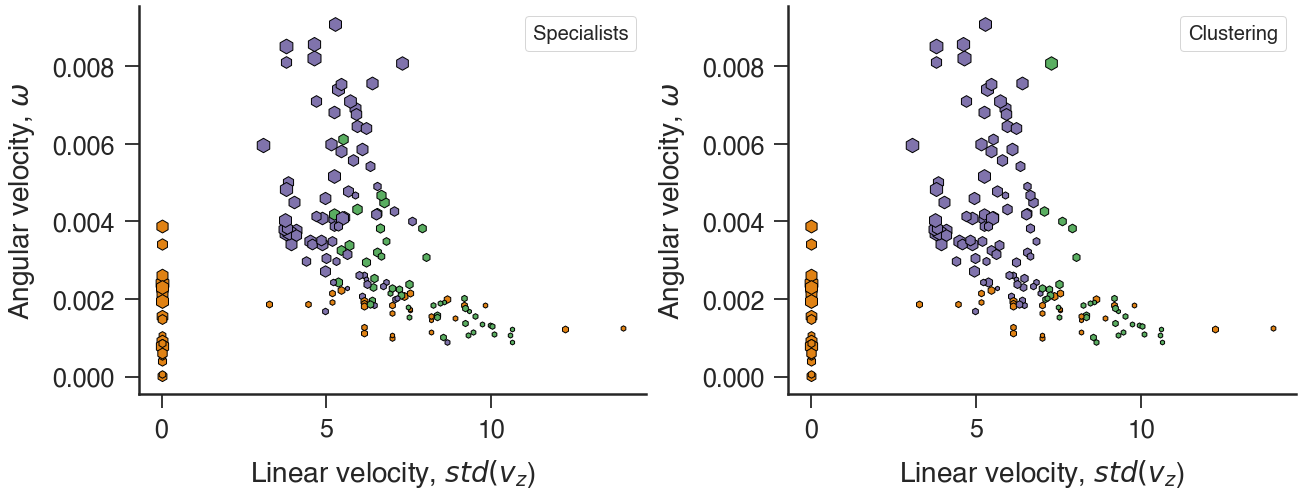

In [17]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214"
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling

#first panel
for osc, vz, class_, size_ in zip(hex_w, hex_vz, hex_human_class, hex_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(hex_w, hex_vz, hex_feat_class, hex_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Specialists'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Clustering'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Hexagon - Complexity-entropy - 2D Observable area time series

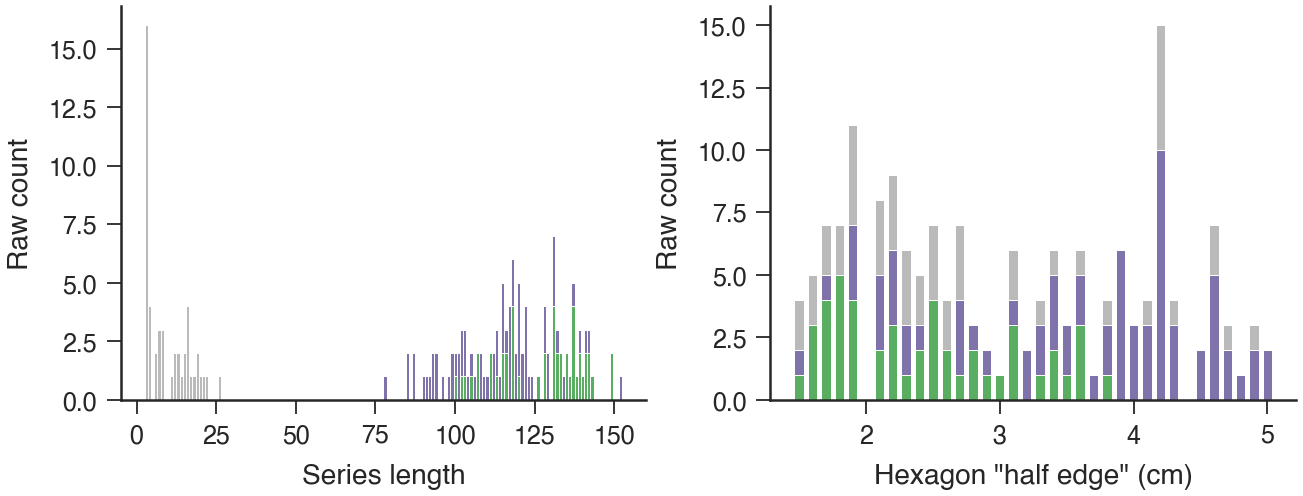

In [18]:
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in hex_trajectories])
x, y    = np.unique([len(i) for i in hex_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(hex_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in hex_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(hex_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Hexagon \"half edge\" (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

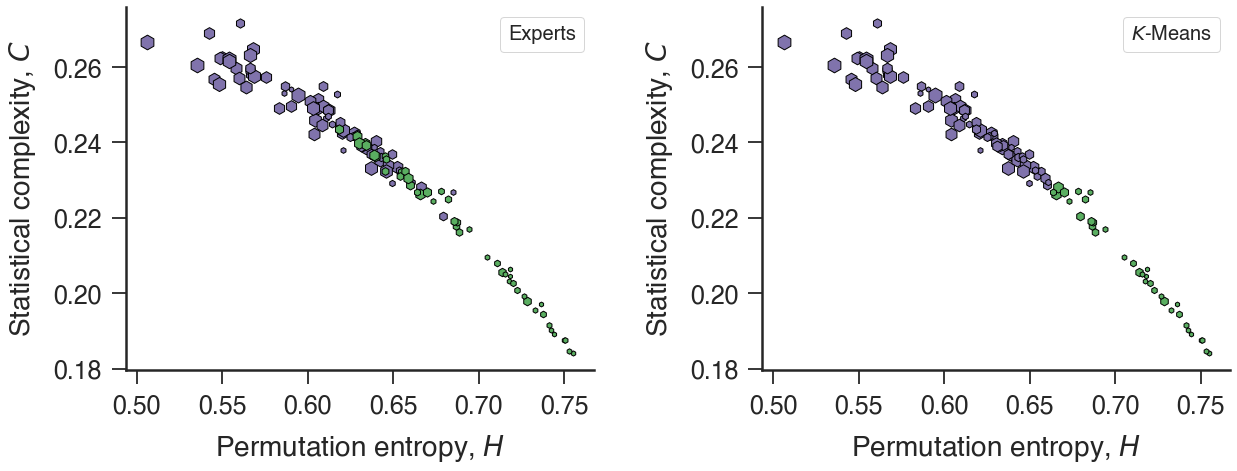

In [19]:
dx_                  = 3
hex_ce_final         = []
hex_lengths          = []
hex_cluster_final    = []
hex_size             = []
hex_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(hex_trajectories)), hex_trajectories, 
                                          hex_cam1, hex_cam2, hex_human_class, hex_radii):

    if class_==3: #steady or periodic time series
        try:
            ts = ts1
            h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
            hex_ce_final.append((h_, c_))
        except:
            hex_ce_final.append((0,0))
            
    else: #tumbling or chaotic time series
        ts = ts1
        h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
        hex_ce_final.append((h_, c_))
        hex_lengths.append(len(ts1))
        hex_cluster_final.append((h_, c_))
        hex_size.append(size_)
        hex_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(hex_ce_final, hex_human_class, hex_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
    if class_ == 3:
        pass
        
#clustering to generate the second panel data
hex_cluster_final          = np.asarray(hex_cluster_final).reshape(-1,2) #standardizing permutation features
scaler                     = StandardScaler()
hex_cluster_final_features = scaler.fit_transform(hex_cluster_final)
hex_pred                   = KMeans(n_clusters=2, random_state=42).fit(hex_cluster_final_features).labels_ 

for (h_, c_), class_, size_ in zip(hex_cluster_final, hex_pred, hex_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(hex_cluster_final, hex_pred, hex_lengths): #marker size proportional to series length
    if class_==1:
        ax[1].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)
    else:
        ax[1].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/hexagon-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

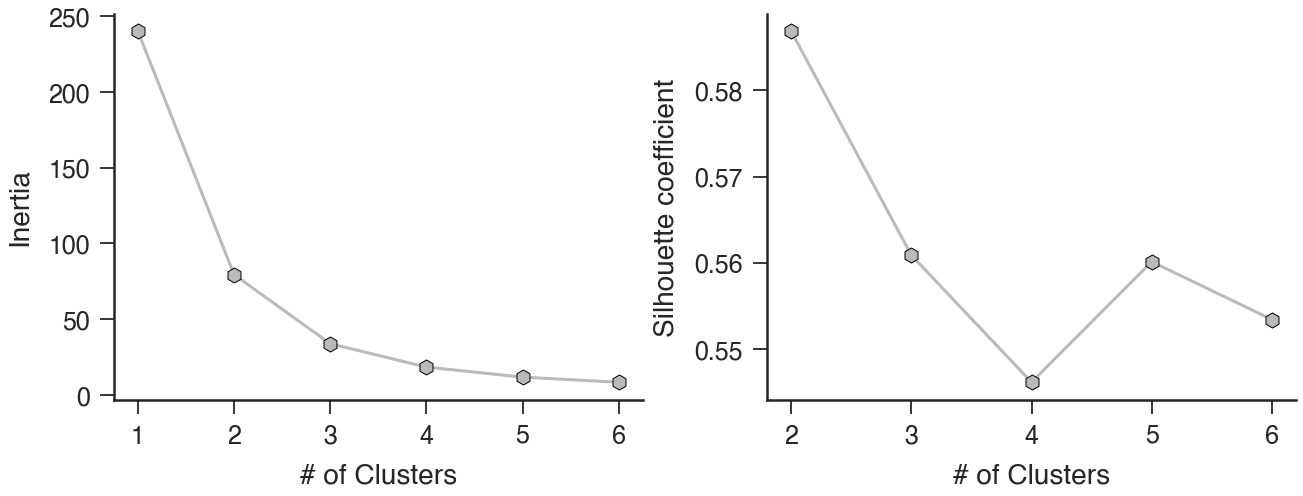

In [20]:
inertia                    = []
KMEANS                     = []
hex_cluster_final          = np.asarray(hex_cluster_final).reshape(-1,2) #standardizing permutation features
scaler                     = StandardScaler()
hex_cluster_final_features = scaler.fit_transform(hex_cluster_final)

for k in range(1,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(hex_cluster_final_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(hex_cluster_final_features))
    # hex_pred             = KMeans(n_clusters=2, random_state=42).fit(hex_cluster_final_features).labels_ 
    

silhouette_kmeans = [silhouette_score(hex_cluster_final_features, kmean_.labels_) for kmean_ in KMEANS[1:]]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([1,2,3,4,5,6], inertia, '-h', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-h', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [ ]:
baseline_random(shape='Hexagon', camera=1)

In [21]:
_, b = np.unique(hex_human_class, return_counts=True)
b    = 100*b/b.sum()

print('Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):')
print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

_, b = np.unique(hex_human_class[hex_human_class!=3], return_counts=True)
b    = 100*b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')


print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
hex_pred_copy = np.where(hex_pred==0, 2, hex_pred)

# hex_pred_copy = np.where(hex_pred==1, 2, hex_pred)
# hex_pred_copy = np.where(hex_pred==0, 1, hex_pred_copy)
print('Accuracy using permutation entropy (statistics) strategy: ', sum(hex_human_chaos_tumb==hex_pred_copy)/len(hex_pred_copy))
print('Accuracy of the original paper                          : ', sum(hex_feat_class[hex_feat_class!=3]==hex_human_class[hex_human_class!=3])/len(hex_feat_class[hex_feat_class!=3]))

Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):
Tumbling         = 28.0%
Chaotic          = 43.0%
Steady/periodic  = 29.0% 

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 39.0%
Chaotic  = 61.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.8416666666666667
Accuracy of the original paper                          :  0.7916666666666666


4it [00:01,  2.99it/s]


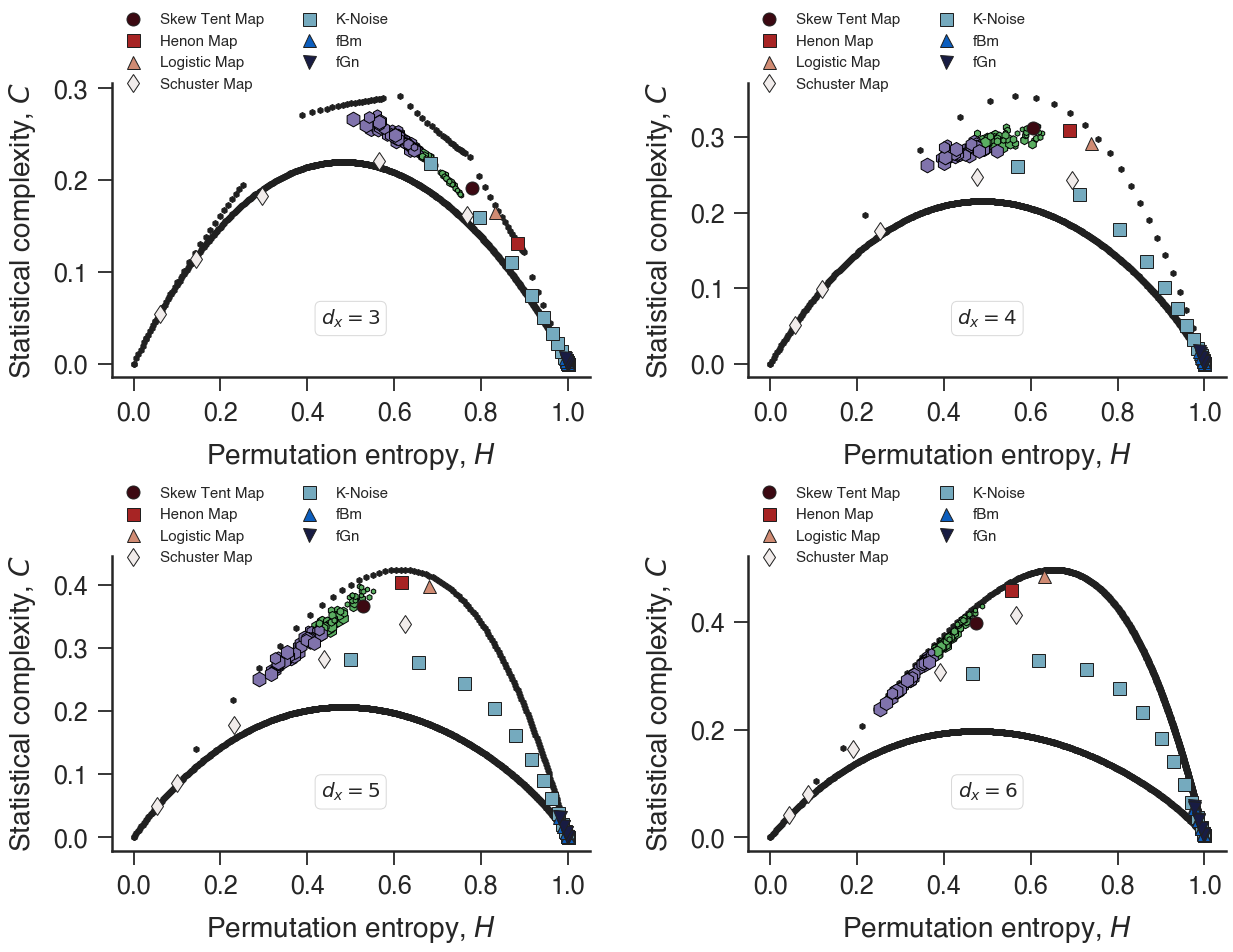

In [159]:
#figure creation
f, ax = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(scale=.95, nrows=2, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"
##################################################################

for dx_, hc_fgn, hc_fbm, hc_schuster_, hc_stentmap_, hc_henon_x_, hc_logistic_, hc_knoise_ in tqdm.tqdm(zip(range(3,7), [hc_fgn_dx3, hc_fgn_dx4, hc_fgn_dx5, hc_fgn_dx6], 
                                                                                                        [hc_fbm_dx3, hc_fbm_dx4, hc_fbm_dx5, hc_fbm_dx6], 
                                                                                                        hc_schuster, hc_stentmap, hc_henon_x, hc_logistic, hc_knoise)):
    k = int(dx_)
    hc_data = [hc_stentmap_, hc_henon_x_, hc_logistic_, hc_schuster_, hc_knoise_, hc_fbm, hc_fgn]
    labels  = ['Skew Tent Map', 'Henon Map', 'Logistic Map', 'Schuster Map', 'K-Noise','fBm', 'fGn']
    markers = ['o', 's', '^', 'd', 's', '^', 'v']
    colors  = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 


    #palettable.cmocean.diverging.Balance_7_r.hex_colors
    colors = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 


    for data_, marker_, color_, label_, cnt in zip(hc_data, markers, colors,
                                                   labels, range(len(hc_data))):
        #point plotting
        h_, c_ = data_.T
        ax[k-3].plot(h_, c_, marker_, markersize=13, markeredgecolor='#202020', color=color_, label=label_)

    if dx_==3:
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_, m =20).T  #(this variable is defined in the cell above)
    else:    
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_).T  #(this variable is defined in the cell above)    
        
    ax[k-3].plot(hmin, cmin, '.', marker='h', color='#202020', zorder=0)    
    ax[k-3].plot(hmax, cmax, '.', marker='h', color='#202020', zorder=0)

    ax[k-3].set_ylabel('Statistical complexity, $C$')
    ax[k-3].set_xlabel('Permutation entropy, $H$')
    ax[k-3].annotate('$d_x = {}$'.format(dx_), (.5, .2),
                   va='center',
                   ha='center',
                   xycoords='axes fraction',
                   fontsize=20,
                   bbox={
                       'boxstyle': 'round',
                       'fc': 'white',
                       'alpha': 1,
                       'ec': '#d9d9d9'
                   })
    ax[k-3].legend(frameon=False, loc=(0, .95), ncol=2, fontsize=15)

    #################################################################
#     dx_                     = dx_
    hex_ce               = []
    hex_lengths          = []
    hex_cluster          = []
    hex_size             = []
    hex_human_chaos_tumb = []

    for i, st, ts1, ts2, class_, size_ in zip(range(len(hex_trajectories)), hex_trajectories, hex_cam1, hex_cam2, hex_human_class, hex_radii):

        if class_==3: #steady or periodic time series
            try:
                ts = ts1
                h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
                hex_ce.append((h_, c_))
            except:
                hex_ce.append((0,0))

        else: #tumbling or chaotic time series
            ts = ts1
            h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
            hex_ce.append((h_, c_))
            hex_lengths.append(len(ts1))
            hex_cluster.append((h_, c_))
            hex_size.append(size_)
            hex_human_chaos_tumb.append(class_)

    #clustering to generate the second panel data
    hex_cluster          = np.asarray(hex_cluster).reshape(-1,2) #standardizing permutation features
    scaler                  = StandardScaler()
    hex_cluster_features = scaler.fit_transform(hex_cluster)
    hex_pred             = KMeans(n_clusters=2, random_state=42).fit(hex_cluster_features).labels_ 

    for (h_, c_), class_, size_ in zip(hex_cluster, hex_pred, hex_size): #marker size proportional to series length
    # for (h_, c_), class_, size_ in zip(hex_cluster, hex_pred, hex_lengths): #marker size proportional to series length
        if class_==1:
            ax[k-3].plot(h_, c_, marker='h', markersize=300*size_, markeredgecolor='black', color=green_, zorder=0)
        else:
            ax[k-3].plot(h_,c_,  marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    

for i in range(4):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
f.savefig('figures/final_figures/observable-area-hexagon-maps-noises-dx3to6.svg', bbox_inches='tight')
# f.savefig('figures/hex-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

# Square  Analysis

In [262]:
#loading cleaned trajectories and some features.
square_trajectories, square_cam1, square_cam2, square_radii, square_conditions, _  = trajectory_cleaning('Square')
square_dx, square_dy, square_dz, square_pathlen, square_time, square_w, square_vz  = original_features(square_trajectories, square_cam1, square_cam2)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [263]:
#Classifications
square_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Square'))['behaviourHuman'][0]
square_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Square'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

## Square - Original features plane (angular velocity vs linear velocity)

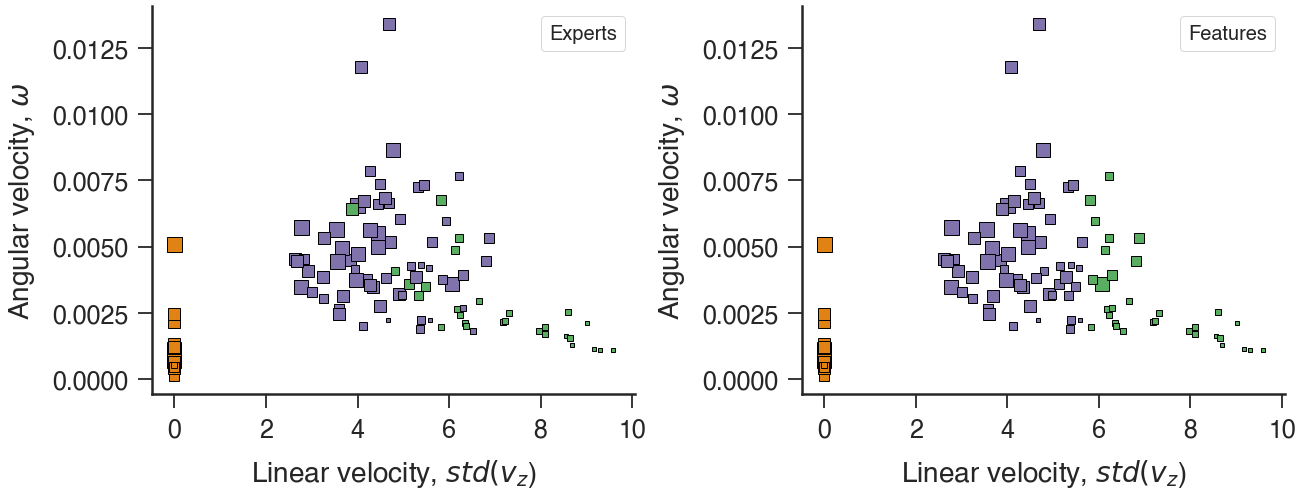

In [24]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214" #steady/periodic
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling

#first panel
for osc, vz, class_, size_ in zip(square_w, square_vz, square_human_class, square_radii):
    if class_==1:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(square_w, square_vz, square_feat_class, square_radii):
    if class_==1:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Features'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Square - Complexity-entropy - 2D Observable area time series

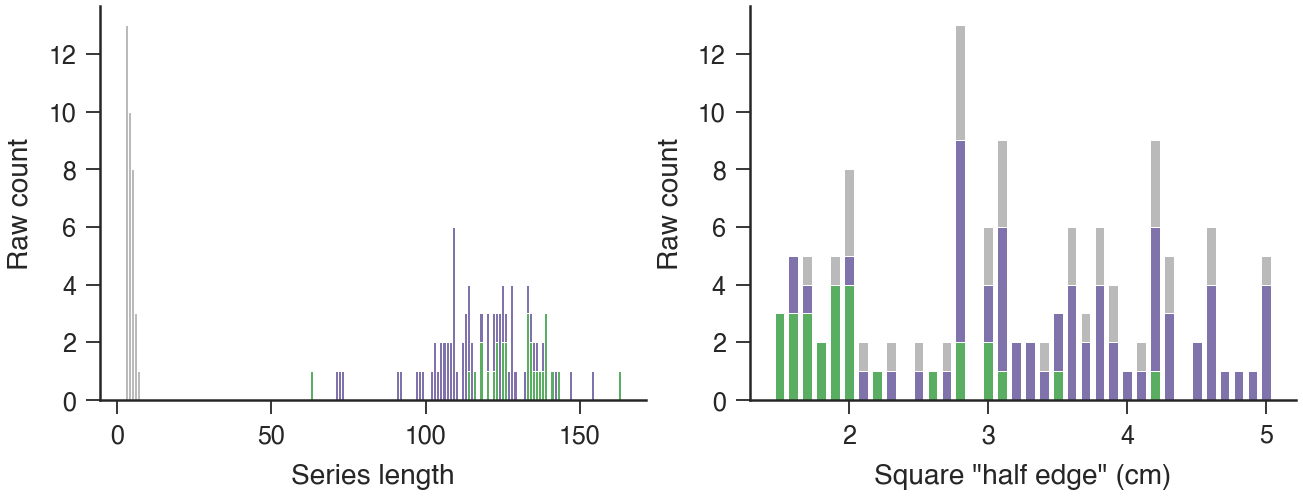

In [264]:
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in square_trajectories])
x, y    = np.unique([len(i) for i in square_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(square_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in square_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(square_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Square \"half edge\" (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

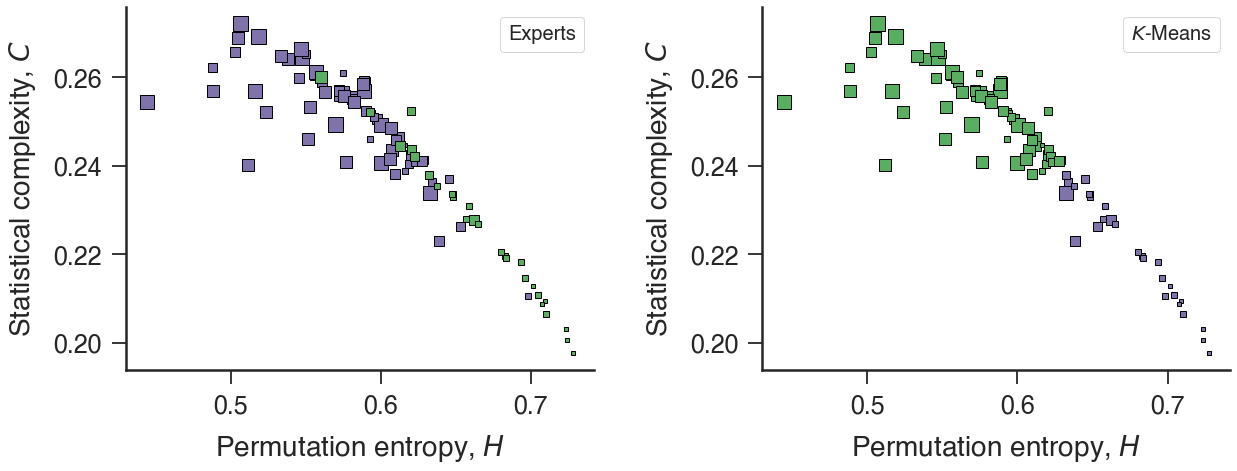

In [265]:
dx_                     = 3
square_ce               = []
square_lengths          = []
square_cluster          = []
square_size             = []
square_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(square_trajectories)), square_trajectories, 
                                          square_cam1, square_cam2, square_human_class, square_radii):

    if class_==3: #steady or periodic time series
        try:
            ts     = ts1 
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=False)
            square_ce.append((h_, c_))
        except:
            square_ce.append((0,0))
            
    else: #tumbling or chaotic time series
        ts     = ts1  
        h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
        
        square_ce.append((h_, c_))
        square_lengths.append(len(ts1))
        square_cluster.append((h_, c_))
        square_size.append(size_)
        square_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(square_ce, square_human_class, square_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
    if class_ == 3:
        pass

#clustering to generate the second panel data
square_cluster          = np.asarray(square_cluster).reshape(-1,2) #standardizing permutation features
scaler                  = StandardScaler()
square_cluster_features = scaler.fit_transform(square_cluster)
square_pred             = KMeans(n_clusters=2, random_state=42).fit(square_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_lengths): #marker size proportional to series length
    if class_==0:
        ax[1].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)
    else:
        ax[1].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/squareagon-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

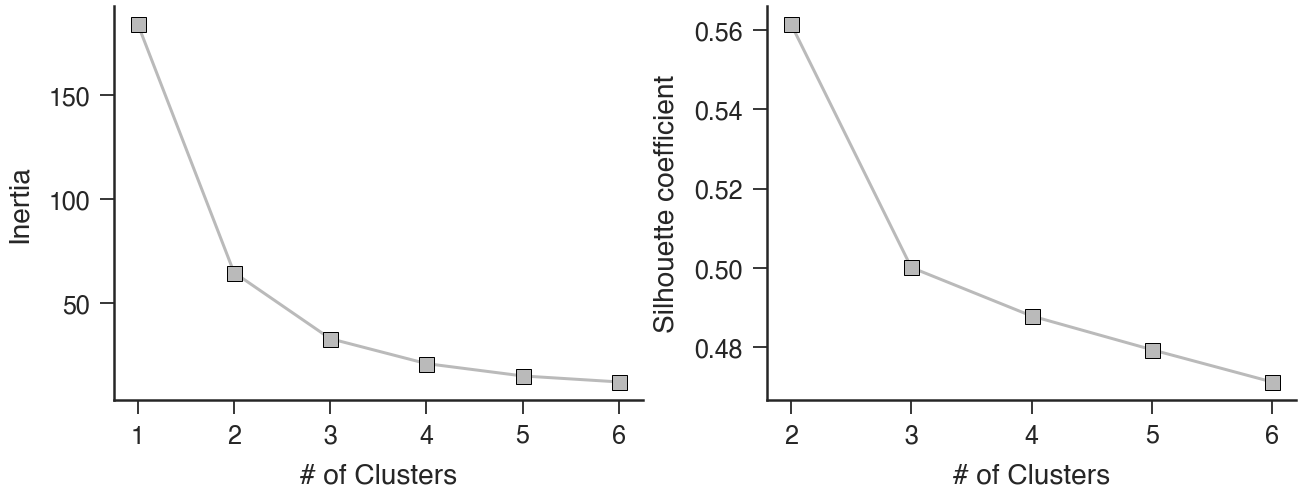

In [266]:
inertia                 = []
KMEANS                  = []
square_cluster          = np.asarray(square_cluster).reshape(-1,2) #standardizing permutation features
scaler                  = StandardScaler()
square_cluster_features = scaler.fit_transform(square_cluster)

for k in range(1,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(square_cluster_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(square_cluster_features))
    # square_pred             = KMeans(n_clusters=2, random_state=42).fit(square_cluster_features).labels_ 
    

silhouette_kmeans = [silhouette_score(square_cluster_features, kmean_.labels_) for kmean_ in KMEANS[1:]]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([1,2,3,4,5,6], inertia, '-s', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-s', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [267]:
baseline_random(shape='Square', camera=1)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
 38%|███▊      | 38/100 [00:03<00:06,  9.71it/s]


KeyboardInterrupt: 

In [269]:
print('Comparison between our clustering and the clustering based on time series statistics (original approach):', '\n')
# # Agreement between the human and the permutation entropy classification (CE)
square_pred_copy = np.where(square_pred==0, 2, square_pred)

# square_pred_copy = np.where(square_pred==1, 2, square_pred)
# square_pred_copy = np.where(square_pred==0, 1, square_pred_copy)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(square_pred_copy==square_human_chaos_tumb)/len(square_pred_copy))
print('Accuracy of the original paper                          : ', sum(square_feat_class[square_feat_class!=3]==square_human_class[square_human_class!=3])/len(square_feat_class[square_feat_class!=3]))

Comparison between our clustering and the clustering based on time series statistics (original approach): 

Accuracy using permutation entropy (statistics) strategy:  0.8695652173913043
Accuracy of the original paper                          :  0.8478260869565217


4it [00:01,  3.56it/s]


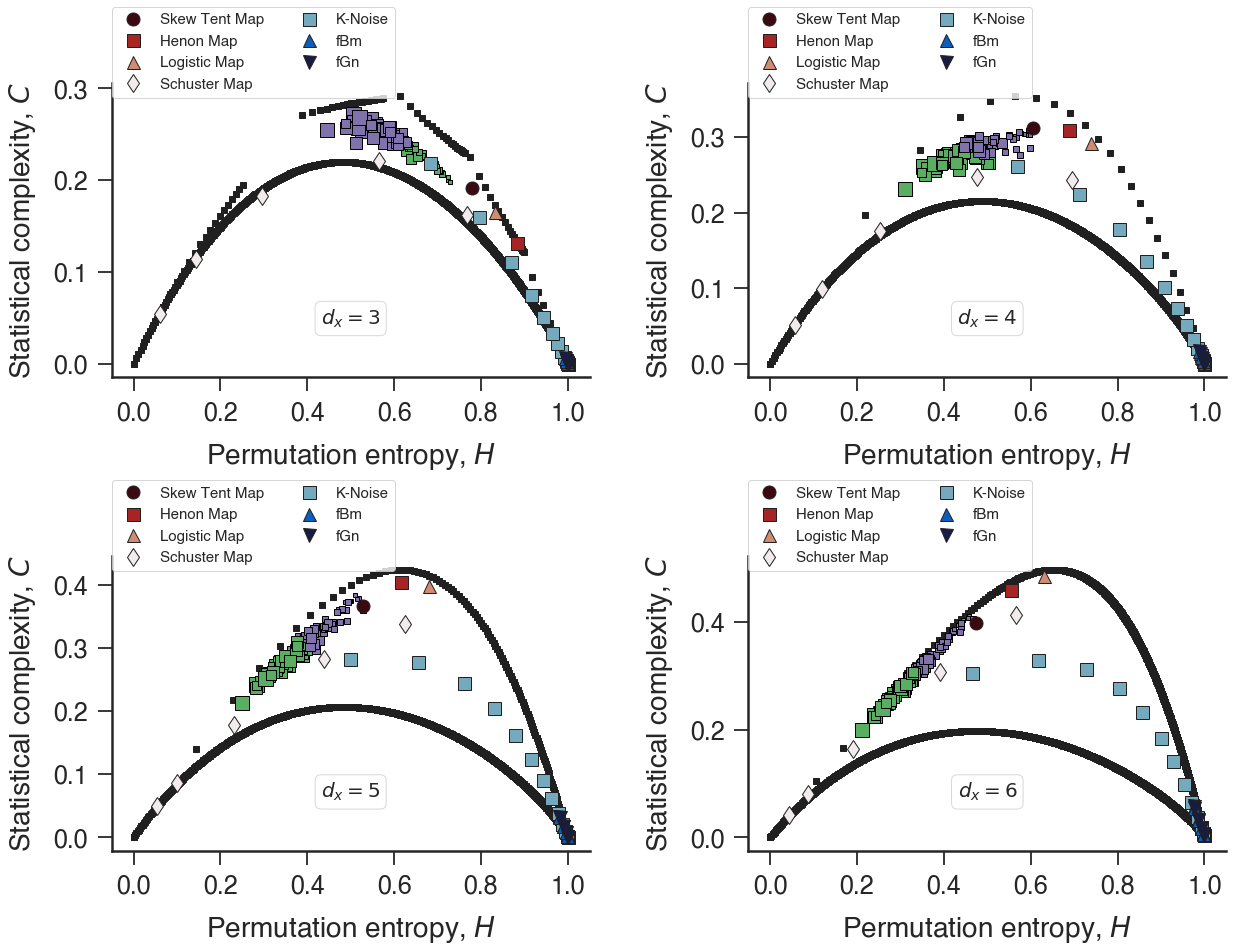

In [158]:
#figure creation
f, ax = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(scale=.95, nrows=2, ncols=2))
ax    = ax.flatten()

##################################################################

for dx_, hc_fgn, hc_fbm, hc_schuster_, hc_stentmap_, hc_henon_x_, hc_logistic_, hc_knoise_ in tqdm.tqdm(zip(range(3,7), [hc_fgn_dx3, hc_fgn_dx4, hc_fgn_dx5, hc_fgn_dx6], 
                                                                                                        [hc_fbm_dx3, hc_fbm_dx4, hc_fbm_dx5, hc_fbm_dx6], 
                                                                                                        hc_schuster, hc_stentmap, hc_henon_x, hc_logistic, hc_knoise)):
    k       = int(dx_)
    hc_data = [hc_stentmap_, hc_henon_x_, hc_logistic_, hc_schuster_, hc_knoise_, hc_fbm, hc_fgn]
    labels  = ['Skew Tent Map', 'Henon Map', 'Logistic Map', 'Schuster Map', 'K-Noise','fBm', 'fGn']
    markers = ['o', 's', '^', 'd', 's', '^', 'v']
    colors  = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 


    #palettable.cmocean.diverging.Balance_7_r.hex_colors
    colors = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 

    for data_, marker_, color_, label_, cnt in zip(hc_data, markers, colors,
                                                   labels, range(len(hc_data))):
        #point plotting
        h_, c_ = data_.T
        ax[k-3].plot(h_, c_, marker_, markersize=13, markeredgecolor='#202020', color=color_, label=label_)

    if dx_==3:
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_, m =20).T  #(this variable is defined in the cell above)
    else:    
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_).T  #(this variable is defined in the cell above)    
        
    ax[k-3].plot(hmin, cmin, '.', marker='s', color='#202020', zorder=0)    
    ax[k-3].plot(hmax, cmax, '.', marker='s', color='#202020', zorder=0)

    ax[k-3].set_ylabel('Statistical complexity, $C$')
    ax[k-3].set_xlabel('Permutation entropy, $H$')
    ax[k-3].annotate('$d_x = {}$'.format(dx_), (.5, .2),
                   va='center',
                   ha='center',
                   xycoords='axes fraction',
                   fontsize=20,
                   bbox={
                       'boxstyle': 'round',
                       'fc': 'white',
                       'alpha': 1,
                       'ec': '#d9d9d9'
                   })
    ax[k-3].legend(frameon=False, loc=(0, .95), ncol=2, fontsize=15)

    #################################################################

    square_ce               = []
    square_lengths          = []
    square_cluster          = []
    square_size             = []
    square_human_chaos_tumb = []

    for i, st, ts1, ts2, class_, size_ in zip(range(len(square_trajectories)), square_trajectories, 
                                              square_cam1, square_cam2, square_human_class, square_radii):

        if class_==3: #steady or periodic time series
            try:
                ts     = ts1
                h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)

                square_ce.append((h_, c_))
            except:
                square_ce.append((0,0))

        else: #tumbling or chaotic time series
            ts     = ts1
            h_, c_ = ordpy.complexity_entropy(ts1, dx=dx_, probs=False)
    
            square_ce.append((h_, c_))
            square_lengths.append(len(ts1))
            square_cluster.append((h_, c_))
            square_size.append(size_)
            square_human_chaos_tumb.append(class_)

    #clustering to generate the second panel data
    square_cluster          = np.asarray(square_cluster).reshape(-1,2) #standardizing permutation features
    scaler                  = StandardScaler()
    square_cluster_features = scaler.fit_transform(square_cluster)
    square_pred             = KMeans(n_clusters=2, random_state=42).fit(square_cluster_features).labels_ 

    for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_size): #marker size proportional to series length
    # for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_lengths): #marker size proportional to series length
        if class_==1:
            ax[k-3].plot(h_, c_, marker='s', markersize=300*size_, markeredgecolor='black', color=green_, zorder=0)
        else:
            ax[k-3].plot(h_,c_,  marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    

for i in range(4):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
f.savefig('figures/final_figures/observable-area-square-maps-noises-dx3to6.svg', bbox_inches='tight')

# Cross  Analysis

In [29]:
#loading cleaned trajectories and some features.
cross_trajectories, cross_cam1, cross_cam2, cross_radii, cross_width, cross_conditions, _  = trajectory_cleaning('Cross')
cross_dx, cross_dy, cross_dz, cross_pathlen, cross_time, cross_w, cross_vz                 = original_features(cross_trajectories, cross_cam1, cross_cam2)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [30]:
#Classifications
cross_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Cross'))['behaviourHuman'][0]
cross_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Cross'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [31]:
# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dx'].flatten()==np.asarray(cross_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dy'].flatten()==np.asarray(cross_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dz'].flatten()==np.asarray(cross_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['pathLength'].flatten(), cross_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['time'].flatten(), cross_time,
#                             range(len(cross_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Cross - Original features plane

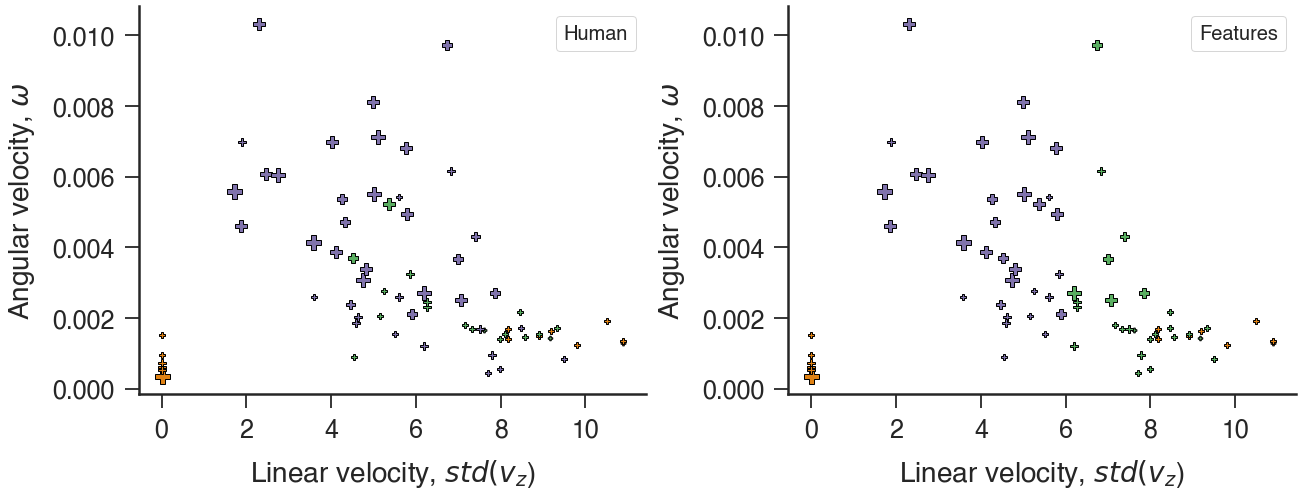

In [32]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

#first panel
for osc, vz, class_, size_ in zip(cross_w, cross_vz, cross_human_class, cross_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(cross_w, cross_vz, cross_feat_class, cross_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Human'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Features'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Cross - Complexity-entropy - 2D Observable area time series

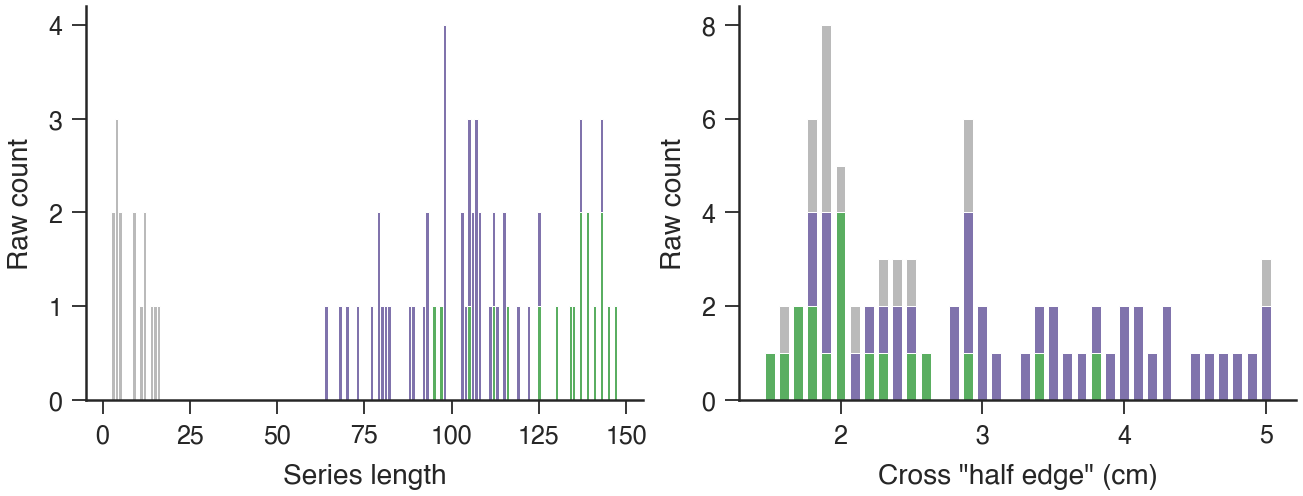

In [33]:
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in cross_trajectories])
x, y    = np.unique([len(i) for i in cross_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(cross_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in cross_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(cross_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Cross \"half edge\" (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

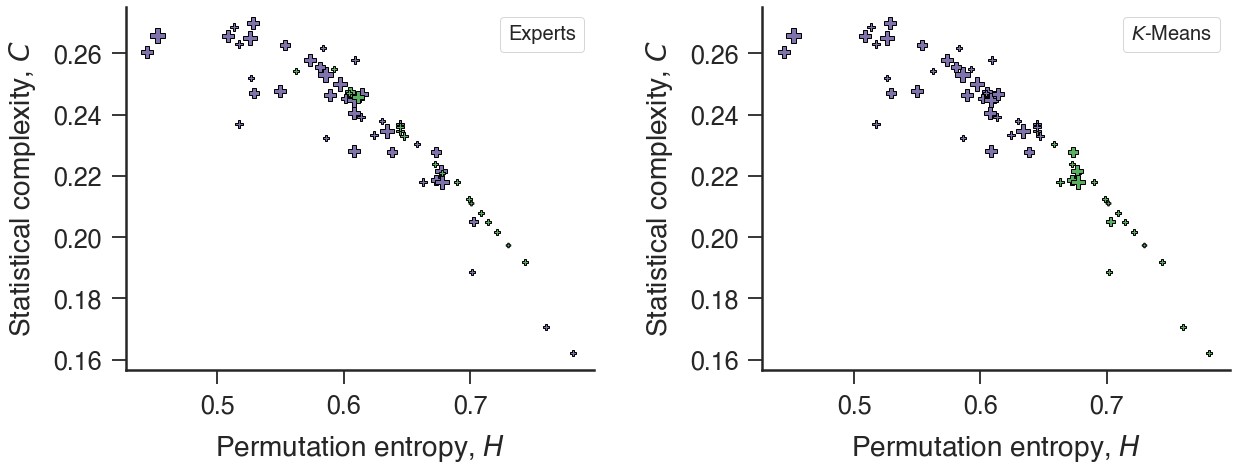

In [34]:
dx_                    = 3
cross_ce               = []
cross_cluster          = []
cross_size             = []
cross_human_chaos_tumb = []
cross_lengths          = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(cross_trajectories)), cross_trajectories, 
                                          cross_cam1, cross_cam2, cross_human_class, cross_radii):

    if class_==3: #steady or periodic time series
        try:
            ts     = ts2
            h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
            cross_ce.append((h_, c_))
        except:
            print("Found a series shorter than {}.".format(dx_))
            cross_ce.append((0,0))
            
    else: #tumbling or chaotic time series
        ts     = ts2           
        h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
        
        cross_ce.append((h_, c_))
        cross_lengths.append(len(ts1))
        cross_cluster.append((h_, c_))
        cross_size.append(size_)
        cross_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(cross_ce, cross_human_class, cross_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='P', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='P', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
    if class_ == 3:
        pass
        
#clustering to generate the second panel data
cross_cluster          = np.asarray(cross_cluster).reshape(-1,2) #standardizing permutation features
scaler                 = StandardScaler()
cross_cluster_features = scaler.fit_transform(cross_cluster)
cross_pred             = KMeans(n_clusters=2, random_state=42).fit(cross_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_lengths): #marker size proportional to series length
    if class_==1:
        ax[1].plot(h_, c_, '.', marker='P', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(h_,c_,  '.', marker='P', markersize=300*size_, markeredgecolor='black', color=green_, zorder=0)    
            
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/cross-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

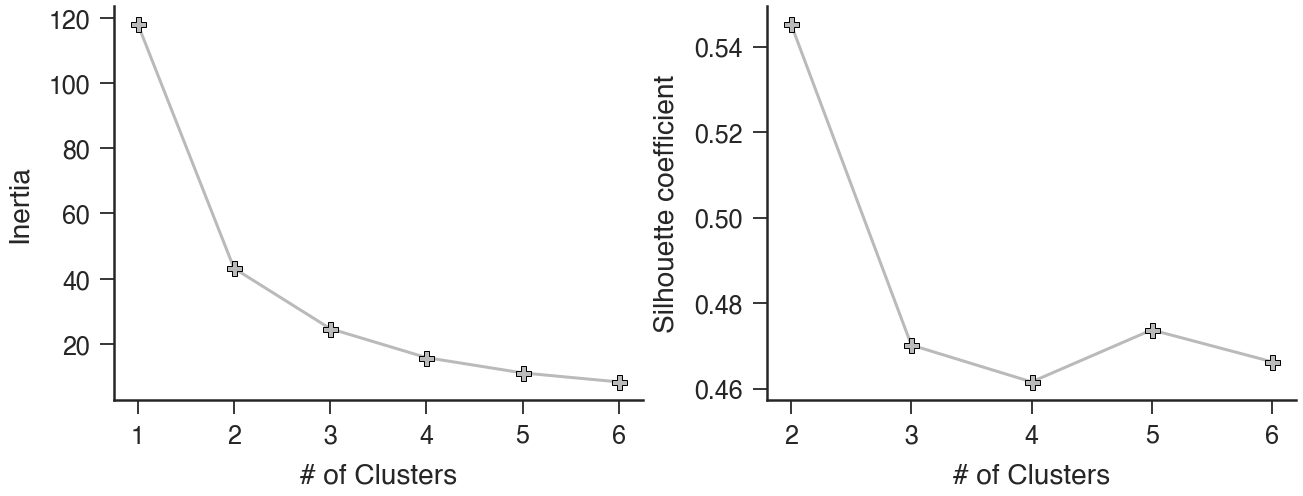

In [35]:
inertia                = []
KMEANS                 = []
cross_cluster          = np.asarray(cross_cluster).reshape(-1,2) #standardizing permutation features
scaler                 = StandardScaler()
cross_cluster_features = scaler.fit_transform(cross_cluster)

for k in range(1,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(cross_cluster_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(cross_cluster_features))
    # cross_pred             = KMeans(n_clusters=2, random_state=42).fit(cross_cluster_features).labels_ 
    

silhouette_kmeans = [silhouette_score(cross_cluster_features, kmean_.labels_) for kmean_ in KMEANS[1:]]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([1,2,3,4,5,6], inertia, '-P', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-P', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [258]:
_, b = np.unique(cross_human_class, return_counts=True)
b    = 100*b/b.sum()

print('Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):')

print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

_, b = np.unique(cross_human_class[cross_human_class!=3], return_counts=True)
b    = 100*b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')

print('Comparison between our clustering and the clustering based on time series statistics (original approach):', '\n')
# cross_pred_copy = np.where(cross_pred==0, 2, cross_pred)

cross_pred_copy = np.where(cross_pred==1, 2, cross_pred)
cross_pred_copy = np.where(cross_pred==0, 1, cross_pred_copy)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(cross_human_chaos_tumb==cross_pred_copy)/len(cross_pred_copy))
print('Accuracy of the original paper                          : ', sum(cross_feat_class[cross_feat_class!=3]==cross_human_class[cross_human_class!=3])/len(cross_feat_class[cross_feat_class!=3]))

Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):
Tumbling         = 24.0%
Chaotic          = 55.0%
Steady/periodic  = 20.0% 

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 31.0%
Chaotic  = 69.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach): 

Accuracy using permutation entropy (statistics) strategy:  0.6949152542372882
Accuracy of the original paper                          :  0.6440677966101694


In [ ]:
baseline_random('Cross')

4it [00:00,  4.32it/s]


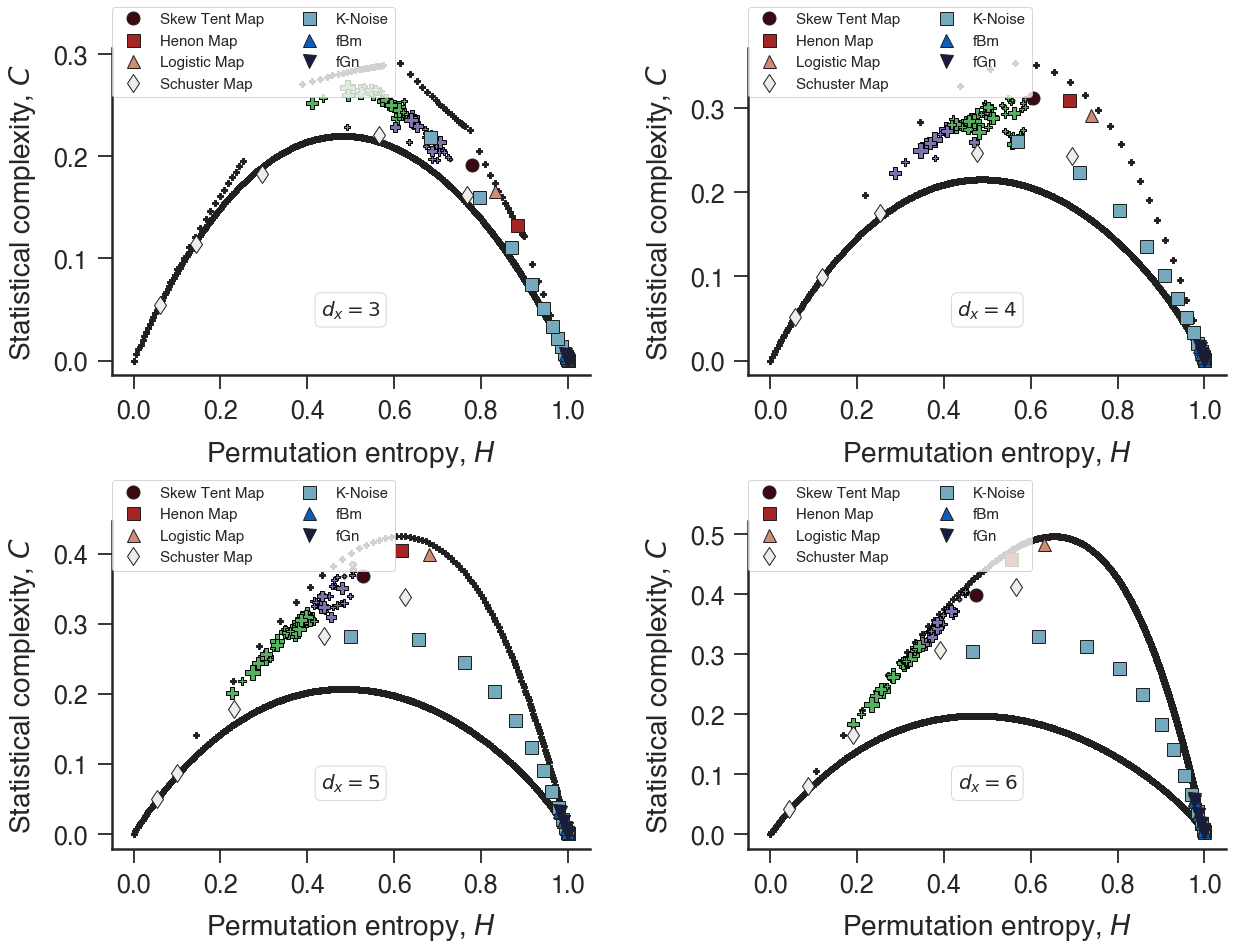

In [37]:
#figure creation
f, ax = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(scale=.95, nrows=2, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

for dx_, hc_fgn, hc_fbm, hc_schuster_, hc_stentmap_, hc_henon_x_, hc_logistic_, hc_knoise_ in tqdm.tqdm(zip(range(3,7), [hc_fgn_dx3, hc_fgn_dx4, hc_fgn_dx5, hc_fgn_dx6], 
                                                                                                        [hc_fbm_dx3, hc_fbm_dx4, hc_fbm_dx5, hc_fbm_dx6], 
                                                                                                        hc_schuster, hc_stentmap, hc_henon_x, hc_logistic, hc_knoise)):
    k       = int(dx_)
    hc_data = [hc_stentmap_, hc_henon_x_, hc_logistic_, hc_schuster_, hc_knoise_, hc_fbm, hc_fgn]
    labels  = ['Skew Tent Map', 'Henon Map', 'Logistic Map', 'Schuster Map', 'K-Noise','fBm', 'fGn']
    markers = ['o', 's', '^', 'd', 's', '^', 'v']
    colors  = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 


    #palettable.cmocean.diverging.Balance_7_r.hex_colors
    colors = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43']

    for data_, marker_, color_, label_, cnt in zip(hc_data, markers, colors,
                                                   labels, range(len(hc_data))):
        #point plotting
        h_, c_ = data_.T
        ax[k-3].plot(h_, c_, marker_, markersize=13, markeredgecolor='#202020', color=color_, label=label_)

    if dx_==3:
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_, m =20).T  #(this variable is defined in the cell above)
    else:    
        hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
        hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_).T  #(this variable is defined in the cell above)    
        
    ax[k-3].plot(hmin, cmin, '.', marker='P', color='#202020', zorder=0)    
    ax[k-3].plot(hmax, cmax, '.', marker='P', color='#202020', zorder=0)

    ax[k-3].set_ylabel('Statistical complexity, $C$')
    ax[k-3].set_xlabel('Permutation entropy, $H$')
    ax[k-3].annotate('$d_x = {}$'.format(dx_), (.5, .2),
                   va='center',
                   ha='center',
                   xycoords='axes fraction',
                   fontsize=20,
                   bbox={
                       'boxstyle': 'round',
                       'fc': 'white',
                       'alpha': 1,
                       'ec': '#d9d9d9'
                   })
    ax[k-3].legend(frameon=True, loc=(0, .85), ncol=2, fontsize=15)

    #################################################################
    cross_ce               = []
    cross_lengths          = []
    cross_cluster          = []
    cross_size             = []
    cross_human_chaos_tumb = []

    for i, st, ts1, ts2, class_, size_ in zip(range(len(cross_trajectories)), cross_trajectories, 
                                              cross_cam1, cross_cam2, cross_human_class, cross_radii):

        if class_==3: #steady or periodic time series
            try:
                ts = ts1
                h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
                cross_ce.append((h_, c_))
            except:
#                 print('Found a time series smaller than dx={}'.format(dx_))
                cross_ce.append((0,0))
    
        else: #tumbling or chaotic time series
            ts = ts1 
            h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
            cross_ce.append((h_, c_))
            cross_lengths.append(len(ts1))
            cross_cluster.append((h_, c_))
            cross_size.append(size_)
            cross_human_chaos_tumb.append(class_)

    #clustering to generate the second panel data
    cross_cluster          = np.asarray(cross_cluster).reshape(-1,2) #standardizing permutation features
    scaler                 = StandardScaler()
    cross_cluster_features = scaler.fit_transform(cross_cluster)
    cross_pred             = KMeans(n_clusters=2, random_state=42).fit(cross_cluster_features).labels_ 

    for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_size): #marker size proportional to series length
    # for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_lengths): #marker size proportional to series length
        if class_==0:
            ax[k-3].plot(h_, c_, marker='P', markersize=300*size_, markeredgecolor='black', color=green_, zorder=0)
        else:
            ax[k-3].plot(h_,c_,  marker='P', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    

for i in range(4):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
f.savefig('figures/final_figures/observable-area-cross-maps-noises-dx3to6.svg', bbox_inches='tight')

# Figures

In [271]:
print('Comparison between our clustering and the clustering based on time series statistics (original approach): HEXAGON', '\n')
hex_pred_copy = np.where(hex_pred==0, 2, hex_pred)

# hex_pred_copy = np.where(hex_pred==1, 2, hex_pred)
# hex_pred_copy = np.where(hex_pred==0, 1, hex_pred_copy)
print('Accuracy using permutation entropy (statistics) strategy: ', sum(hex_human_chaos_tumb==hex_pred_copy)/len(hex_pred_copy))
print('Accuracy of the original paper                          : ', sum(hex_feat_class[hex_feat_class!=3]==hex_human_class[hex_human_class!=3])/len(hex_feat_class[hex_feat_class!=3]), '\n\n\n')


print('Comparison between our clustering and the clustering based on time series statistics (original approach): SQUARE', '\n')
# # Agreement between the human and the permutation entropy classification (CE)
square_pred_copy = np.where(square_pred==0, 2, square_pred)

# square_pred_copy = np.where(square_pred==1, 2, square_pred)
# square_pred_copy = np.where(square_pred==0, 1, square_pred_copy)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(square_pred_copy==square_human_chaos_tumb)/len(square_pred_copy))
print('Accuracy of the original paper                          : ', sum(square_feat_class[square_feat_class!=3]==square_human_class[square_human_class!=3])/len(square_feat_class[square_feat_class!=3]), '\n\n\n')


print('Comparison between our clustering and the clustering based on time series statistics (original approach): CROSS', '\n')
# cross_pred_copy_ts = np.where(cross_pred==0, 2, cross_pred)

cross_pred_copy_ts = np.where(cross_pred==1, 2, cross_pred)
cross_pred_copy_ts = np.where(cross_pred==0, 1, cross_pred_copy_ts)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(cross_human_chaos_tumb==cross_pred_copy_ts)/len(cross_pred_copy_ts))
print('Accuracy of the original paper                          : ', sum(cross_feat_class[cross_feat_class!=3]==cross_human_class[cross_human_class!=3])/len(cross_feat_class[cross_feat_class!=3]))

Comparison between our clustering and the clustering based on time series statistics (original approach): HEXAGON 

Accuracy using permutation entropy (statistics) strategy:  0.8416666666666667
Accuracy of the original paper                          :  0.7916666666666666 



Comparison between our clustering and the clustering based on time series statistics (original approach): SQUARE 

Accuracy using permutation entropy (statistics) strategy:  0.8695652173913043
Accuracy of the original paper                          :  0.8478260869565217 



Comparison between our clustering and the clustering based on time series statistics (original approach): CROSS 

Accuracy using permutation entropy (statistics) strategy:  0.6949152542372882
Accuracy of the original paper                          :  0.6440677966101694


In [63]:
print('Number of time series of falling (CIRCULAR) papers    :', len(circle_pred))

print('Number of time series of falling (HEXAGONAL) papers   :', len(hex_pred))

print('Number of time series of falling (SQUARED) papers     :', len(square_pred))

print('Number of time series of falling (CROSS SHAPED) papers:', len(cross_pred))

Number of time series of falling (CIRCULAR) papers    : 170
Number of time series of falling (HEXAGONAL) papers   : 120
Number of time series of falling (SQUARED) papers     : 92
Number of time series of falling (CROSS SHAPED) papers: 59


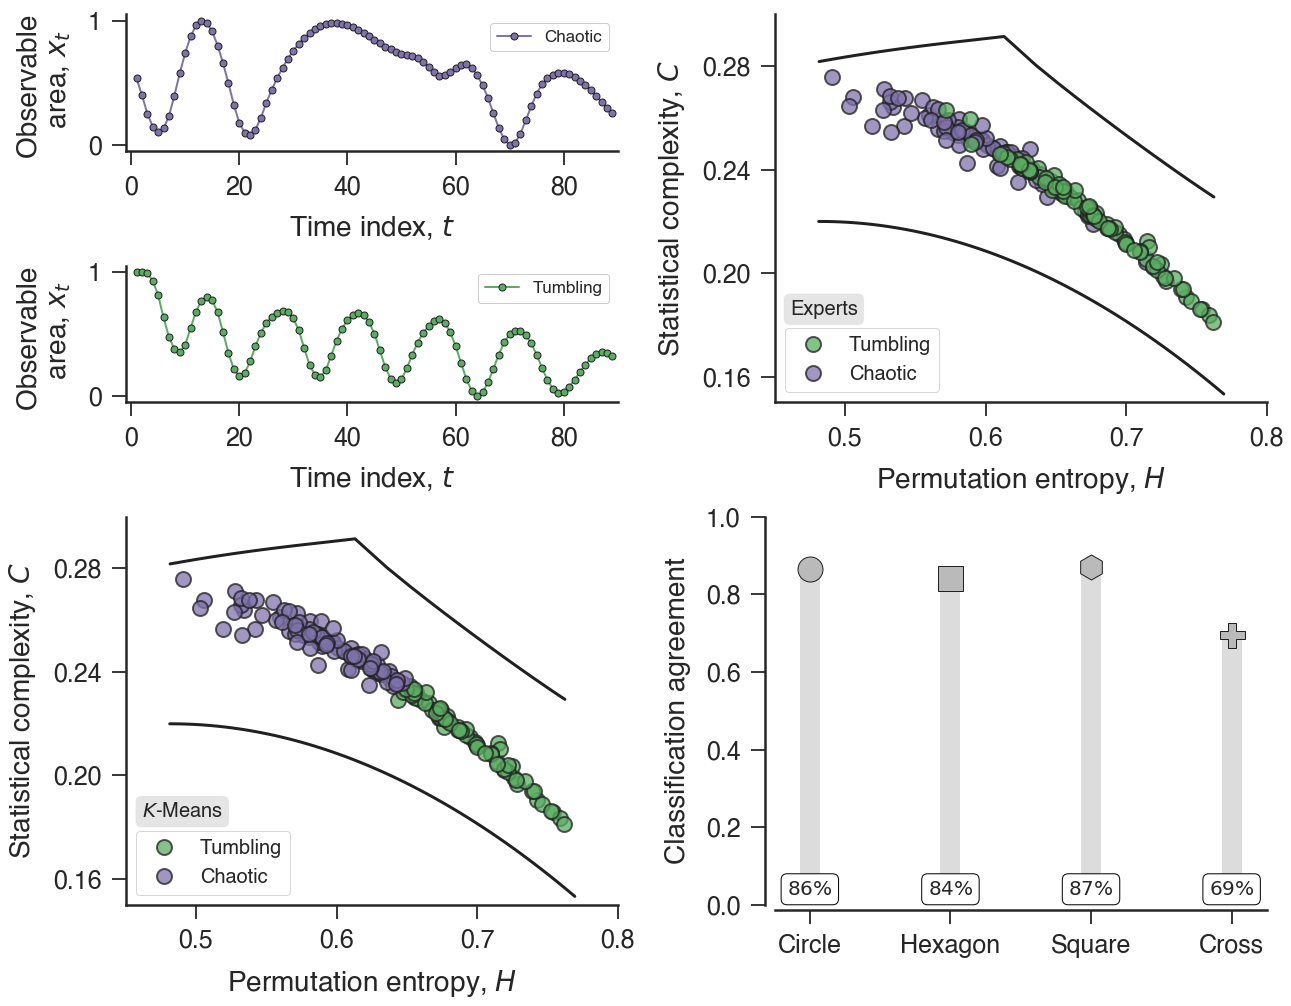

In [248]:
f  = plt.figure(figsize=stdfigsize(nrows=2, ncols=2))
ax = f.subplot_mosaic(
    """
    AACC
    BBCC
    DDFF
    DDFF
    """)
ax = list(ax.values())

#################################################################################### Time series examples; first panel.
colors    = [green_, purple_, grey_]
indices   = [87, 52, 69]
behaviors = ['Tumbling', 'Chaotic', 'Steady']

for index, j, behavior_, cl_, marker_ in zip(indices, [1, 2], behaviors, colors, ['-o','-o']):
    y = normalize(circle_cam1[index][:89])
    x = range(1, len(y)+1)

    ax[j].plot(x, y, marker_, color=cl_, markersize=7, label=behavior_, linewidth=2, markeredgecolor='#202020')
    ax[j].legend(frameon=True, loc='upper right', fontsize=17, framealpha=1)
#     ax[j].legend(frameon=False, fontsize=17)
    ax[j].set_xlim(-1, 90)
    
    
#     ax[1].set_ylabel(' '*30+'Observable area, $x_t$')
    ax[j].set_ylabel('Observable \n area, $x_t$',multialignment='center')
    ax[j].set_xlabel('Time index, $t$')
#     if j==2:
#         ax[j].set_xlabel('Time index, $t$')
#     else:
#         ax[j].tick_params(bottom=True)
#         ax[j].set_xticklabels('')

#################################################################################### Classification experts; second panel
hmin, cmin = ordpy.minimum_complexity_entropy(dx=dx_, size=719).T  #(this variable is defined in the cell above)
hmin_select = hmin[(hmin>.48) & (hmin<.77)]
cmin_select = cmin[(hmin>.48) & (hmin<.77)]

hmax, cmax = ordpy.maximum_complexity_entropy(dx=dx_, m =20).T  #(this variable is defined in the cell above)
hmax_select = hmax[(hmax>.48) & (hmax<.77)]
cmax_select = cmax[(hmax>.48) & (hmax<.77)]


pass1=False
pass2=False
i, j  = 0, 0
for (h_, c_), class_, size_ in zip(circle_ce_final, circle_human_class, circle_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        if not pass1:
            ax[0].plot(h_, c_, '.', marker='o', markersize=15, markeredgecolor='#202020', label='Tumbling', color=green_, alpha=0.75, markeredgewidth=2)
            pass1=True
        else:
            ax[0].plot(h_, c_, '.', marker='o', markersize=15, markeredgecolor='#202020', color=green_, alpha=0.75, markeredgewidth=2)
    elif class_ == 2: #chaotic
        if not pass2:
            ax[0].plot(h_,c_,  '.', marker='o', markersize=15, markeredgecolor='#202020', label='Chaotic', color=purple_, zorder=0, alpha=0.75,  markeredgewidth=2)
            pass2=True
        else:
            ax[0].plot(h_,c_,  '.', marker='o', markersize=15, markeredgecolor='#202020', color=purple_, zorder=0, alpha=0.75,  markeredgewidth=2)
    if class_ == 3:
        pass
    
ax[0].plot(hmin_select[::2], cmin_select[::2], '-', color='#202020', linewidth=3, zorder=0)    
ax[0].plot(hmax_select, cmax_select, '-', color='#202020', linewidth=3, zorder=0)
ax[0].set_xlim(0.45,0.8)
ax[0].set_ylim(0.15,0.3)
ax[0].set_yticks(np.arange(0.16,0.31, 0.04))
ax[0].legend(loc='lower left')
# ax[0].annotate('Experts', xy=(0.02,0.235), xycoords='axes fraction',fontsize=20)
ax[0].annotate('Experts', (.10, .24),  va='center', ha='center', xycoords='axes fraction',fontsize=20,
                bbox={'boxstyle':'round', 'fc':'grey', 'alpha':.2, 'ec':'#d9d9d9'})
# plt.annotate()
# legend.get_title().set_fontsize('20')

ax[0].set_ylabel('Statistical complexity, $C$')
ax[0].set_xlabel('Permutation entropy, $H$')    
    

#################################################################################### Results K-Means; third panel

pass2=False
i, j  = 0, 0
for (h_, c_), class_, size_ in zip(circle_cluster_final, circle_pred, circle_size):
    if class_==0:
        if not pass2:
            ax[3].plot(h_,c_,  '.', marker='o', markersize=15, markeredgecolor='#202020', label='Tumbling', color=green_, zorder=0, alpha=0.75,  markeredgewidth=2)
            pass2=True
        else:
            ax[3].plot(h_,c_,  '.', marker='o', markersize=15, markeredgecolor='#202020', color=green_, zorder=0, alpha=0.75,  markeredgewidth=2)

pass1=False
i, j  = 0, 0
for (h_, c_), class_, size_ in zip(circle_cluster_final, circle_pred, circle_size):
    if class_ == 1: 
        if not pass1:
            ax[3].plot(h_, c_, '.', marker='o', markersize=15, markeredgecolor='#202020', label='Chaotic', color=purple_, alpha=0.75, markeredgewidth=2)
            pass1=True
        else:
            ax[3].plot(h_, c_, '.', marker='o', markersize=15, markeredgecolor='#202020', color=purple_, alpha=0.75, markeredgewidth=2)
    
    
ax[3].set_ylim(0.15,0.3)
ax[3].set_yticks(np.arange(0.16,0.31, 0.04))
ax[3].legend(loc='lower left')


ax[3].set_ylabel('Statistical complexity, $C$')
ax[3].set_xlabel('Permutation entropy, $H$')
    
ax[3].annotate('$K$-Means', (.115, .24),  va='center', ha='center', xycoords='axes fraction',fontsize=20,
                bbox={'boxstyle':'round', 'fc':'grey', 'alpha':.2, 'ec':'#d9d9d9'})

        
#plotting min-max curves
ax[3].plot(hmin_select[::2], cmin_select[::2], '-', color='#202020', linewidth=3, zorder=0)    
ax[3].plot(hmax_select, cmax_select, '-', color='#202020', linewidth=3, zorder=0)
ax[3].set_xlim(0.45,0.8)

# hmin_dots_right = hmin[hmin>.77]
# cmin_dots_right = cmin[hmin>.77]
# hmin_dots_left = hmin[hmin<.48]
# cmin_dots_left = cmin[hmin<.48]

# hmax_dots_right = hmax[hmax>.77]
# cmax_dots_right = cmax[hmax>.77]
# hmax_dots_left = hmax[hmax<.48]
# cmax_dots_left = cmax[hmax<.48]

# step_min = 3
# step_max = 1
# for k in [0, 3]:
#     ax[k].plot(hmin_dots_right[::step_], cmin_dots_right[::step_], '.', color='#202020', linewidth=3, zorder=0)    
#     ax[k].plot(hmin_dots_left[::step_], cmin_dots_left[::step_], '.', color='#202020', linewidth=3, zorder=0)    
    
#     ax[k].plot(hmax_dots_right[::step_max], cmax_dots_right[::step_max], '.', color='#202020', linewidth=3, zorder=0)    
#     ax[k].plot(hmax_dots_left[::step_max], cmax_dots_left[::step_max], '.', color='#202020', linewidth=3, zorder=0)    
    
#################################################################################### Bar plot; last panel
circle_results = sum(circle_human_chaos_tumb==circle_pred_copy)/len(circle_pred_copy)
hex_results    = sum(hex_human_chaos_tumb==hex_pred_copy)/len(hex_pred_copy)
square_results = sum(square_pred_copy==square_human_chaos_tumb)/len(square_pred_copy)
cross_results  = sum(cross_human_chaos_tumb==cross_pred_copy)/len(cross_pred_copy) 

results        = [circle_results, hex_results, square_results, cross_results]


x_ = np.arange(.3,3, .8)
ax[4].vlines(x_,
             ymin=0,
             ymax=results,
             linewidth=20,
             color=grey_,
             alpha=.5)


for i, j, k in zip(x_, results, ['o', 's', 'h', 'P']):
    ax[4].plot(i,
               j,
               k,
               markersize=25,
               color=grey_,
               markeredgecolor='#202020',
               label='Simulation',
               alpha=1)
    

ax[4].set_xticks(x_)
ax[4].set_xticklabels(['Circle', 'Hexagon', 'Square', 'Cross'])

ax[4].spines['bottom'].set_position(('outward', 5))  # outward by 10 points
ax[4].spines['left'].set_position(('outward', 10))  # outward by 10 points

ax[4].set_xlim(0.1,2.9)
ax[4].set_ylim(0,1)
ax[4].set_ylabel('Classification agreement')

for i, j in zip(x_, results):
    ax[4].annotate('${}\%$'.format(round(j*100)), (i, 0.04),
                   va='center',
                   ha='center',
                   xycoords='data',
                   fontsize=20,
                   bbox={'boxstyle': 'round', 'fc': 'white',  'ec':'black', 'alpha': 1}
                   )

# for (letter, index), y_ in zip(list(enumerate([0]*4)), [1.]*4):
#     ax[index].annotate('(' + string.ascii_lowercase[letter] + ')', (0, y_), xycoords='axes fraction', fontsize=35)


f.tight_layout(w_pad=3)
# f.savefig('figures/final_figures/fig1_dots.svg', bbox_inches='tight')
f.savefig('figures/final_figures/fig1.svg', bbox_inches='tight')

/home/arthur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


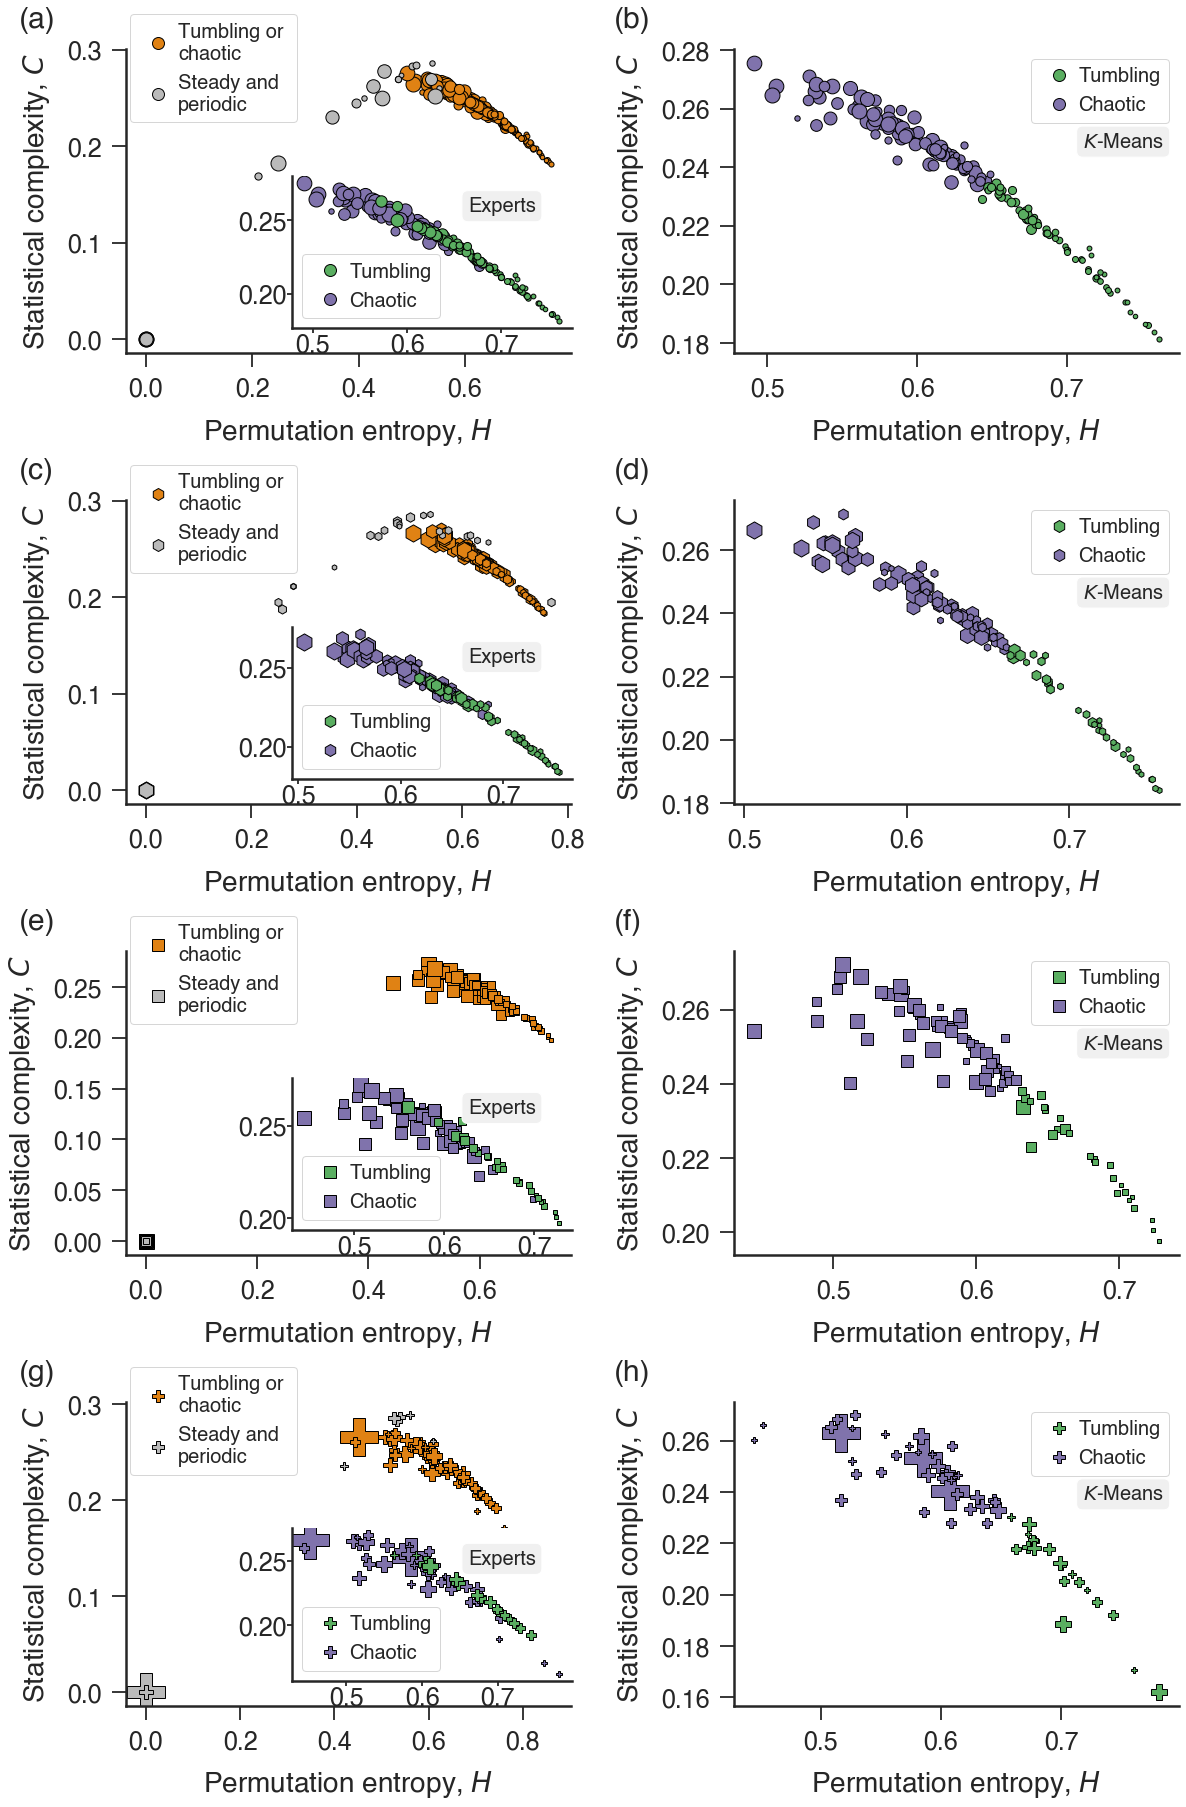

In [37]:
#altering the number of rows (nrows), one can control
f, ax = plt.subplots(nrows=4, ncols=2, figsize=stdfigsize(scale=.9, nrows=4, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

data_plots_left = [
                [circle_ce_final, circle_human_class, 300*np.asarray(circle_radii)],
                [hex_ce_final, hex_human_class, 350*np.asarray(hex_radii)],
                [square_ce, square_human_class, 300*np.asarray(square_radii)],
                [cross_ce, cross_human_class, np.sqrt(10000*np.multiply(cross_radii,cross_width)*30)]
                ]
                
# for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, np.sqrt(np.asarray(cross_size)*30)):
    
data_plots_right = [
                [circle_cluster_final, circle_pred_copy, 300*np.asarray(circle_size)],
                [hex_cluster_final, hex_pred_copy, 350*np.asarray(hex_size)],
                [square_cluster, square_pred_copy, 300*np.asarray(square_size)],
                [cross_cluster, cross_pred_copy, np.sqrt(10000*np.multiply(cross_radii,cross_width)*30)]
                ]

plot_markers = ['o', 'h', 's', 'P']

for data, marker_, ax_ in zip(data_plots_left, plot_markers, ax[0::2]):
    #inset
    axins = inset_axes(ax_, width="90%", height="100%",
                       bbox_to_anchor=(.35, .05, .7, .5),
                       bbox_transform=ax_.transAxes, loc=3)
    axins.tick_params(length=5, pad=0)
    
    i, j, k = 0, 0, 0
    for (h_, c_), class_, size_ in zip(data[0], data[1], data[2]): #periodic, tumbling and chaotic
        if class_ == 1: #tumbling
            if not i==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=orange_)
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=green_)
            else:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=orange_, label='Tumbling or \nchaotic')
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=green_, label='Tumbling')
                i+=1
        elif class_ == 2: #chaotic
            if not j==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=orange_, zorder=0)
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, zorder=0)
            else:
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
                j+=1
        if class_ == 3:
            if not k==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=grey_)
            else:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=grey_, label='Steady and\nperiodic')
                k+=1
    
    if not marker_=='h':
        #legend        
        axlgnd = ax_.legend(loc=[.01,.76], handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)

        
        #inset legend
        axins_lgnd = axins.legend(loc='lower left', handletextpad=0)
        axins_lgnd.legendHandles[0]._legmarker.set_markersize(12)
        axins_lgnd.legendHandles[1]._legmarker.set_markersize(12)
    else:
        handles, labels = ax_.get_legend_handles_labels()
        axlgnd = ax_.legend(handles[::-1], labels[::-1],  loc=[.01,.76], handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)

        handles, labels = axins.get_legend_handles_labels()
        axins_lgnd = axins.legend(handles[::-1], labels[::-1], handletextpad=0, numpoints=1)
        axins_lgnd.legendHandles[0]._legmarker.set_markersize(12)
        axins_lgnd.legendHandles[1]._legmarker.set_markersize(12)

    axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
                   bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
        
# #second column
for data, marker_, ax_ in zip(data_plots_right, plot_markers, ax[1::2]):    
    i, j = 0, 0
    for (h_, c_), class_, size_ in zip(data[0], data[1], data[2]):
        if class_==2:
            if not i==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, zorder=0)
            else:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
                i+=1
        else:
            if not j==0:
                ax_.plot(h_,c_,  '.', marker=marker_, markersize=size_, markeredgecolor='black', color=green_)    
            else:
                ax_.plot(h_,c_,  '.', marker=marker_, markersize=size_, markeredgecolor='black', label='Tumbling', color=green_)    
                j+=1
                
    if not marker_=='o':
        #legend        
        axlgnd = ax_.legend(handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)
    else:
        handles, labels = ax_.get_legend_handles_labels()
        axlgnd = ax_.legend(handles[::-1], labels[::-1], handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)
                    

    ax_.annotate('$K$-Means', (.875, .695),va='center',ha='center', xycoords='axes fraction', fontsize=20,
               bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

for i in range(0, len(ax)):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

    
for (i, ax_), x_ in zip(list(enumerate(ax)), [-.24,-.27]*4):
    ax_.annotate('(' + string.ascii_lowercase[i] + ')', (x_, 1.07),
                 xycoords='axes fraction',
                 fontsize=30,
                 )
    
f.tight_layout(w_pad=3)
f.savefig('figures/final_figures/fig-s1.pdf', dpi=300, bbox_inches='tight')